In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
from scipy.integrate import quad, fixed_quad
import matplotlib.pyplot as plt
import pickle
import numpy as np
import functools
import sys
from tqdm import tqdm, trange
from aemulusnu_hmf_lib.utils import *
from aemulusnu_massfunction.emulator_training import *

from classy import Class

import math
import torch
import gpytorch
from matplotlib import pyplot as plt

import pyccl as ccl


In [3]:
gpytorch.__version__

'1.12'

In [4]:

cosmos_f = open('../data/cosmo_params.pkl', 'rb')
cosmo_params = pickle.load(cosmos_f) #cosmo_params is a dict
cosmos_f.close()

a_list_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/alist.pkl'
a_list_f = open(a_list_fname, 'rb')
a_list = pickle.load(a_list_f)
a_list_f.close()

In [5]:
print(key_ordering)

['10^9 As', 'ns', 'H0', 'w0', 'ombh2', 'omch2', 'nu_mass_ev']


In [6]:
weird_boxes = []


errors = {a:{} for a in a_list}
X = []
Y = []
z_to_a = {}
a_to_z = {}
kt = np.logspace(-3, 1, 100) # h/Mpc
for box in tqdm(cosmo_params):
    if(box in weird_boxes):
        continue
    curr_cosmo = cosmo_params[box]
    if(box == 'Box_n50_0_1400'):
        print(curr_cosmo)

    curr_cosmo_values = [curr_cosmo[curr_key] for curr_key in key_ordering]

    h = curr_cosmo['H0']/100

    Ωb =  curr_cosmo['ombh2'] / h**2
    Ωc =  curr_cosmo['omch2'] / h**2

    cosmo = ccl.Cosmology(Omega_c=Ωc,
                          Omega_b=Ωb,
                          h=h,
                          A_s=curr_cosmo['10^9 As']*10**(-9),
                          n_s=curr_cosmo['ns'],
                          w0=curr_cosmo['w0'],
                          m_nu=[curr_cosmo['nu_mass_ev']/3, curr_cosmo['nu_mass_ev']/3, curr_cosmo['nu_mass_ev']/3])


    try:
        with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_params.pkl"%(box), "rb") as f:
            MLE_params = pickle.load(f)
            param_values = list(MLE_params.values())
            Y+= [param_values]
            X+= [curr_cosmo_values]
    except:
        print(box, z)
    for a in a_list:
        z = scaleToRedshift(a)
        z_to_a[z] = a
        a_to_z[a] = z

100%|██████████| 150/150 [00:00<00:00, 1597.57it/s]

{'ns': 0.97000003, 'H0': 67.0, 'w0': -1.0, 'ombh2': 0.0223, 'omch2': 0.12, 'nu_mass_ev': 0.07071068, '10^9 As': 2.10100315}


In [7]:
X = np.array(X)
Y = np.array(Y)

print(X.shape)
print(Y.shape)
################################
print('scaling input')
in_scaler = Normalizer()
in_scaler.fit(X)
X = in_scaler.transform(X)
print(X.shape)


print('scaling output')
out_scaler = Identity()
out_scaler.fit(Y)
Y = out_scaler.transform(Y)
print(Y.shape)

##REMEMBER TO UNSCALE OUTPUT AND SAVE SCALERS#####

X_train = torch.from_numpy(X).float()
Y_train = torch.from_numpy(Y).float()
n_tasks = len(Y_train[0])

(150, 7)
(150, 8)
scaling input
(150, 7)
scaling output
(150, 8)


In [8]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_tasks,
                                                              has_global_noise=True, 
                                                              has_task_noise=False,
                                                              noise_constraint=gpytorch.constraints.LessThan(1e-8)
                                                             )
likelihood.noise = 1e-8  # Some small value, but don't make it too small or numerical performance will suffer. I recommend 1e-4.
likelihood.raw_noise.requires_grad_(False)  # Mark that we don't want to train the noise.


model = MultitaskGPModel(X_train, Y_train, likelihood)


# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()


training_iterations = 1000

In [9]:
epochs_iter = tqdm(range(training_iterations), desc="Iteration")


# Create the optimizer with the initial learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, amsgrad=True)  # Includes GaussianLikelihood parameters

for i in epochs_iter:
    # Training step
    model.train()
    likelihood.train()

    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, Y_train)
    epochs_iter.set_postfix(loss=loss.item())
    loss.backward()
    optimizer.step()
#     print('Iter %d/%d - Loss: %.4f' % (i + 1, training_iterations, loss.item()))

#     if i == 100:
#         lr = 0.01
#         print('reducing lr to %f'%lr)
#         for param_group in optimizer.param_groups:
#             param_group['lr'] = lr

    if i == 500:
        lr = 0.001
        print('reducing lr to %f'%lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    if i == 1000:
        lr = 0.0001
        print('reducing lr to %f'%lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr


Iteration:  51%|█████     | 511/1000 [00:11<00:12, 37.64it/s, loss=-2.43]  

reducing lr to 0.001000


Iteration: 100%|██████████| 1000/1000 [00:33<00:00, 29.88it/s, loss=-2.43]


In [10]:
model.state_dict()

OrderedDict([('likelihood.raw_noise', tensor([inf])),
             ('likelihood.raw_noise_constraint.lower_bound', tensor(-inf)),
             ('likelihood.raw_noise_constraint.upper_bound',
              tensor(1.0000e-08)),
             ('mean_module.base_means.0.weights',
              tensor([[-0.1946],
                      [-0.0728],
                      [ 0.0216],
                      [ 0.0814],
                      [ 0.0667],
                      [-0.3369],
                      [ 0.0135]])),
             ('mean_module.base_means.0.bias', tensor([2.3440])),
             ('mean_module.base_means.1.weights',
              tensor([[ 0.0343],
                      [ 0.0239],
                      [ 0.0222],
                      [ 0.1749],
                      [ 0.0026],
                      [ 0.0078],
                      [-0.0092]])),
             ('mean_module.base_means.1.bias', tensor([-0.1070])),
             ('mean_module.base_means.2.weights',
              tensor([[

In [11]:
import aemulusnu_massfunction
print(aemulusnu_massfunction.__file__)

import os

package_path = os.path.dirname(aemulusnu_massfunction.__file__)
print(package_path)

/home/users/delon/aemulusnu_massfunction/aemulusnu_massfunction/__init__.py
/home/users/delon/aemulusnu_massfunction/aemulusnu_massfunction


In [12]:

with open(package_path + "/emulator.pkl", "wb") as f:
    pickle.dump([model,
                in_scaler,
                out_scaler,
                likelihood,], f)



In [13]:
Emulator = AemulusNu_HMF_Emulator()

loading emulator from /home/users/delon/aemulusnu_massfunction/aemulusnu_massfunction/emulator.pkl


  0%|          | 0/50 [00:00<?, ?it/s]

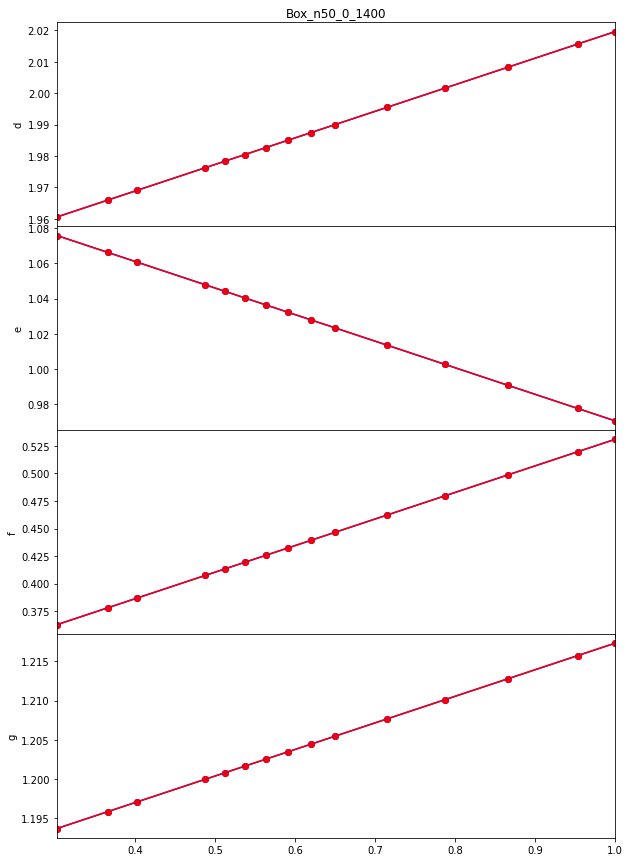

  2%|▏         | 1/50 [00:01<01:05,  1.33s/it]

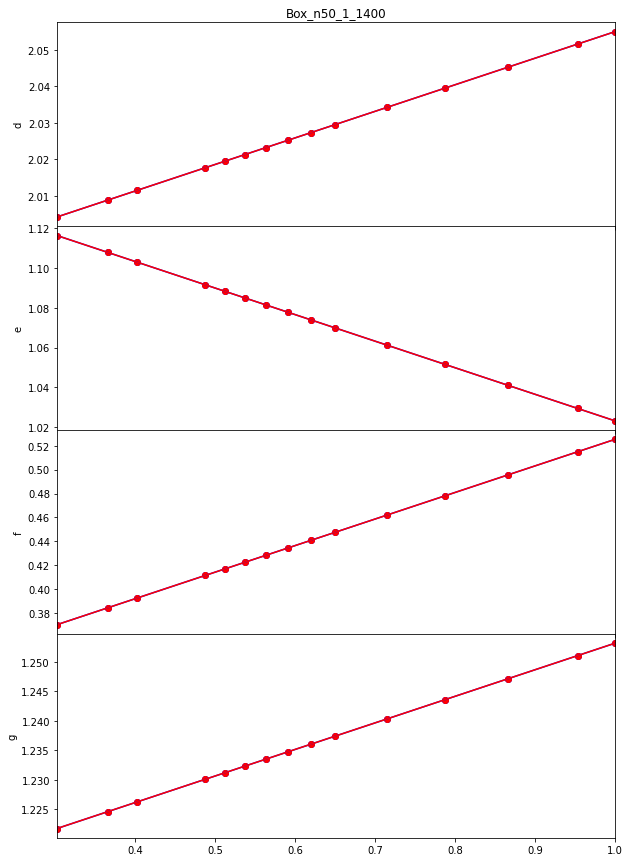

  4%|▍         | 2/50 [00:01<00:43,  1.09it/s]

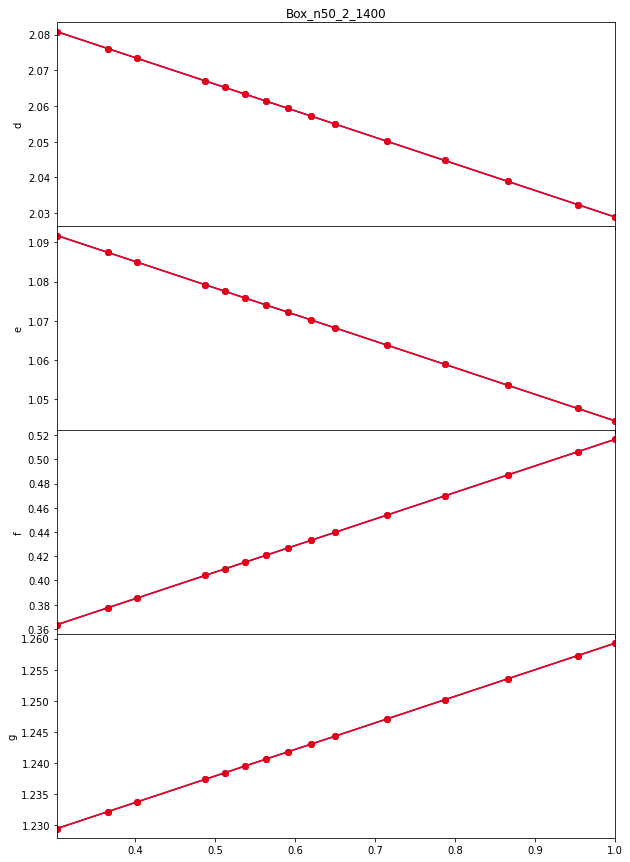

  6%|▌         | 3/50 [00:02<00:33,  1.40it/s]

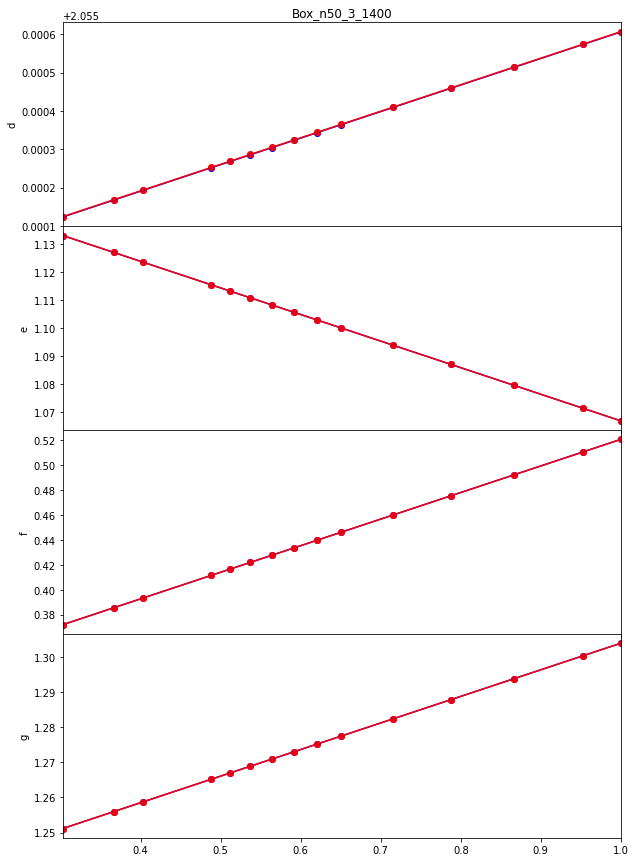

  8%|▊         | 4/50 [00:02<00:28,  1.64it/s]

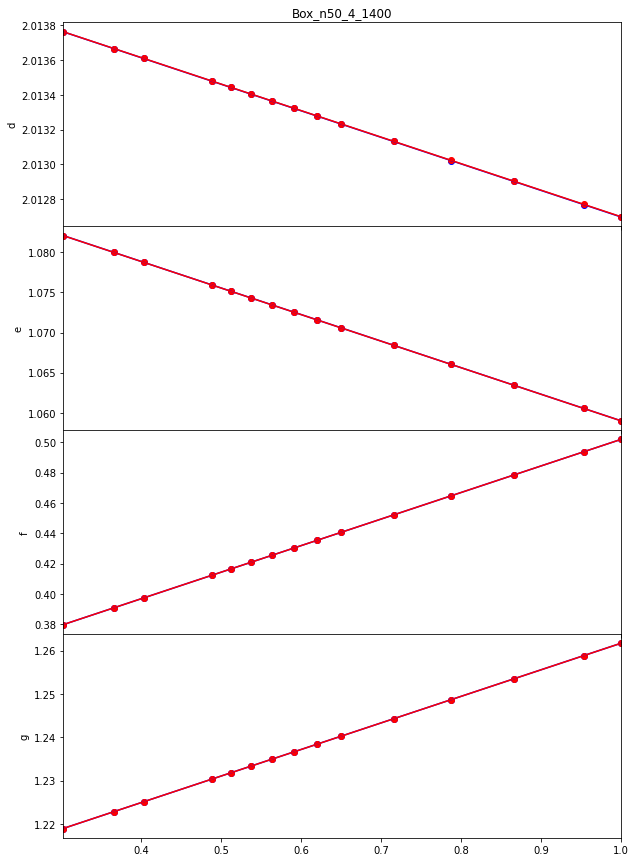

 10%|█         | 5/50 [00:03<00:25,  1.74it/s]

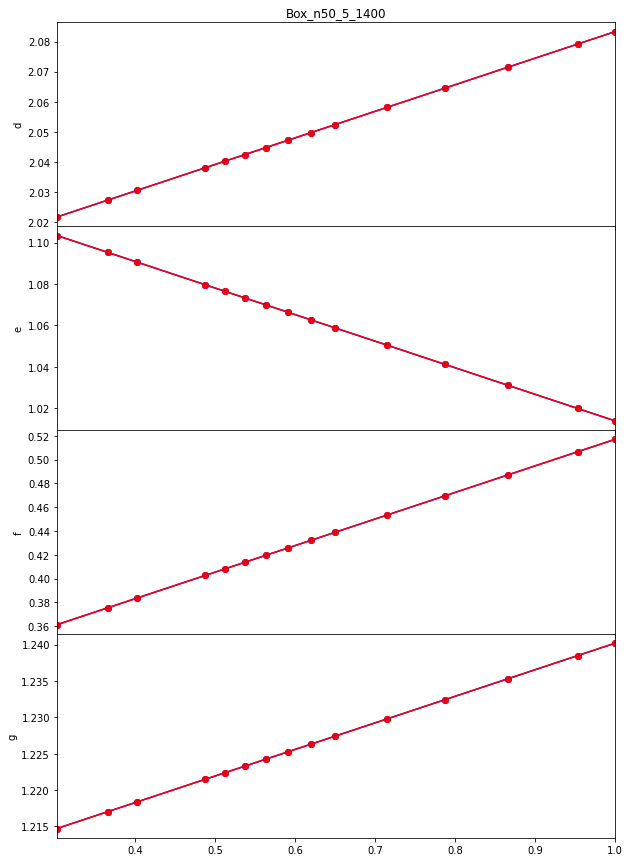

 12%|█▏        | 6/50 [00:03<00:23,  1.90it/s]

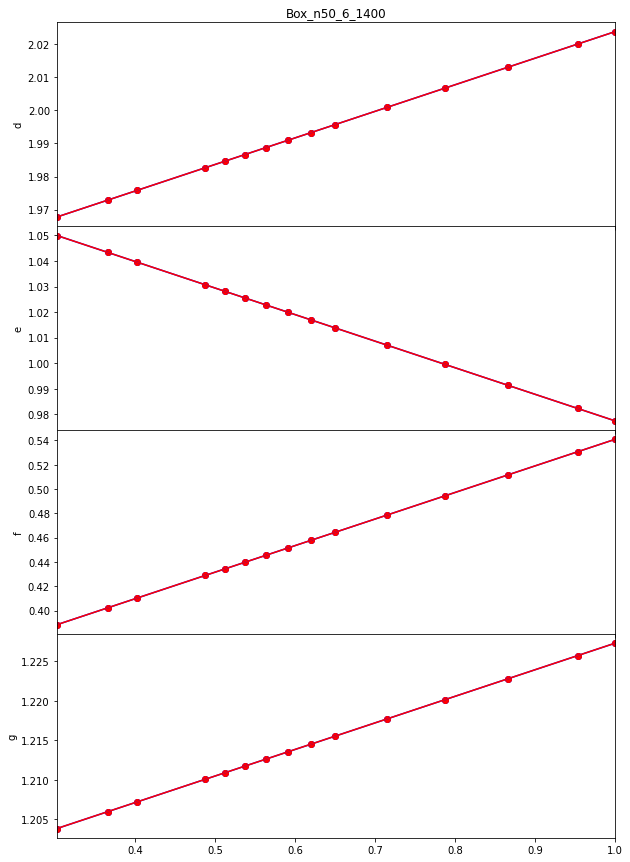

 14%|█▍        | 7/50 [00:04<00:21,  2.00it/s]

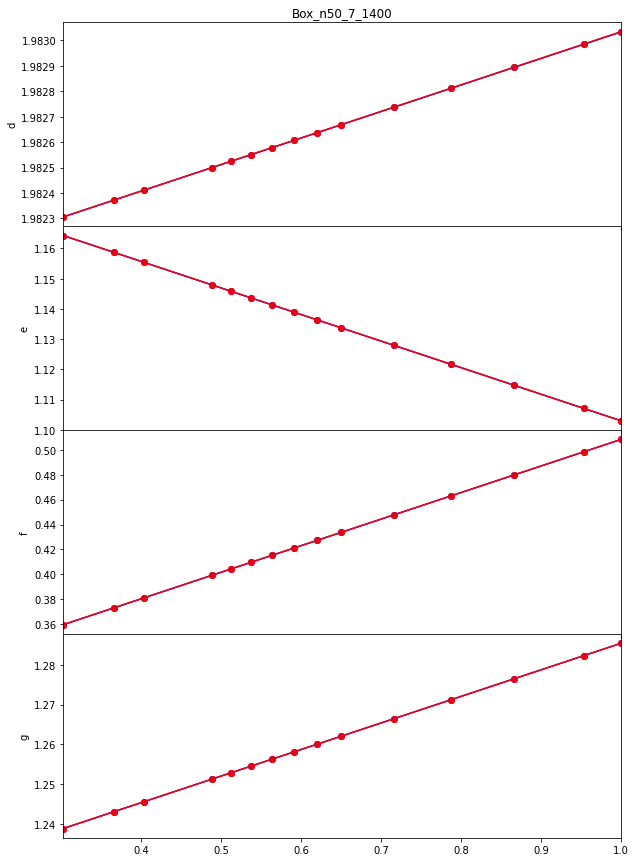

 16%|█▌        | 8/50 [00:04<00:23,  1.78it/s]

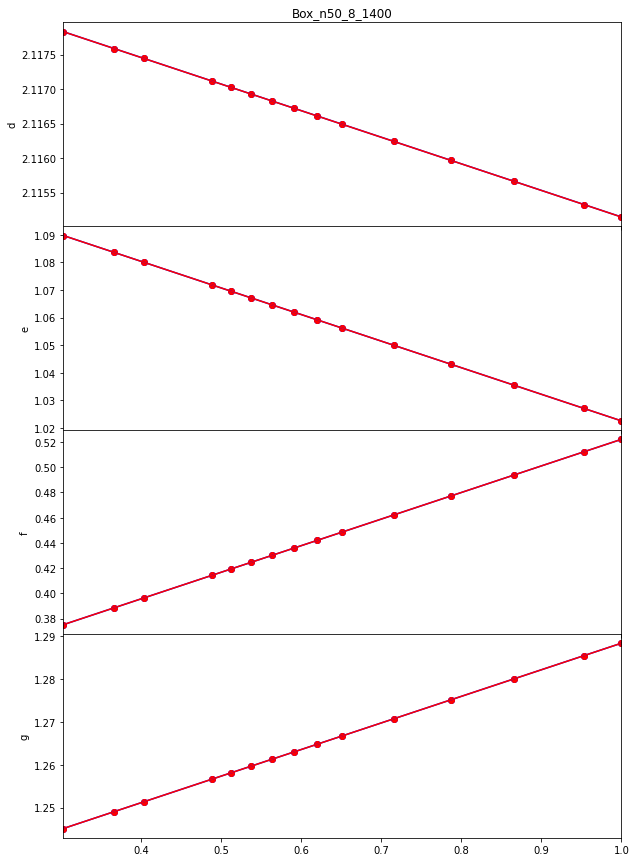

 18%|█▊        | 9/50 [00:05<00:22,  1.86it/s]

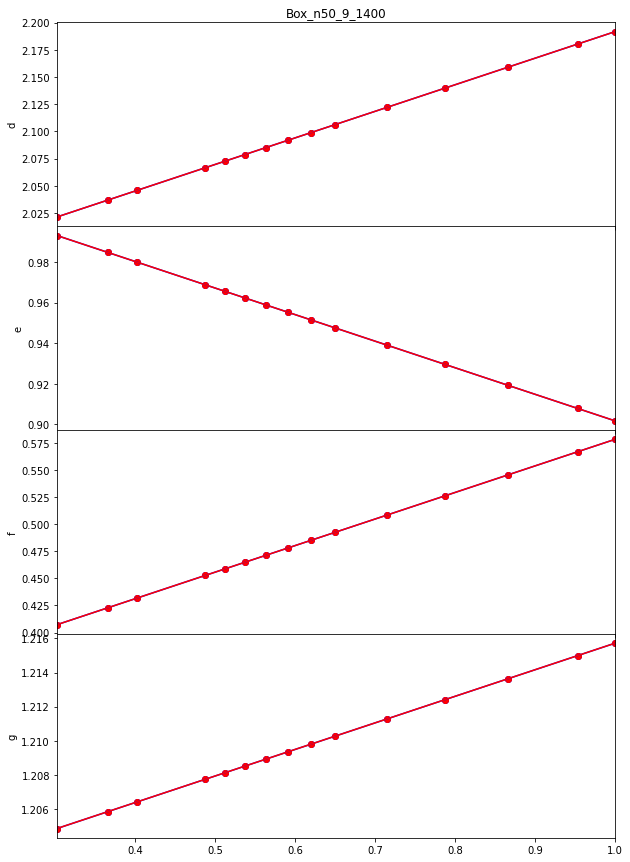

 20%|██        | 10/50 [00:05<00:20,  1.95it/s]

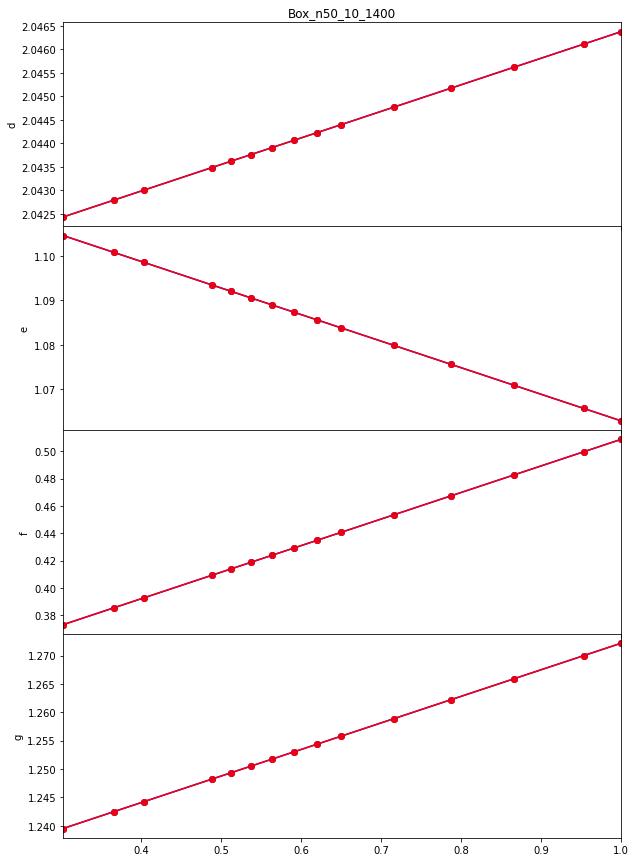

 22%|██▏       | 11/50 [00:06<00:19,  2.05it/s]

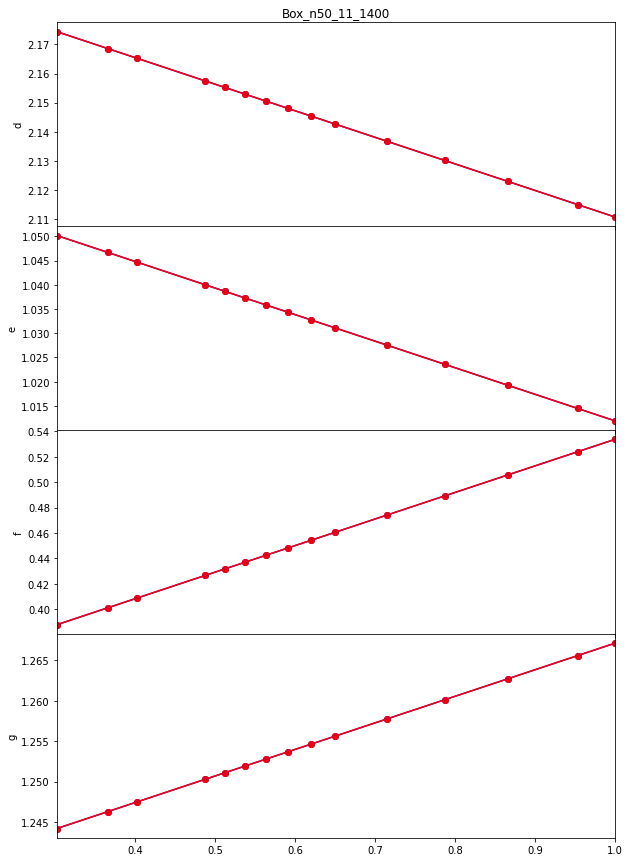

 24%|██▍       | 12/50 [00:06<00:17,  2.14it/s]

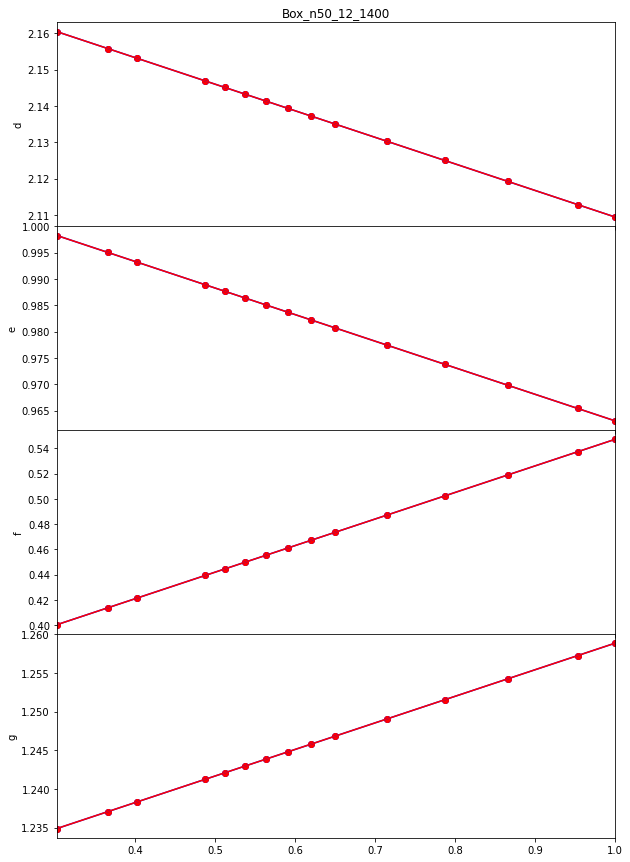

 26%|██▌       | 13/50 [00:07<00:18,  2.00it/s]

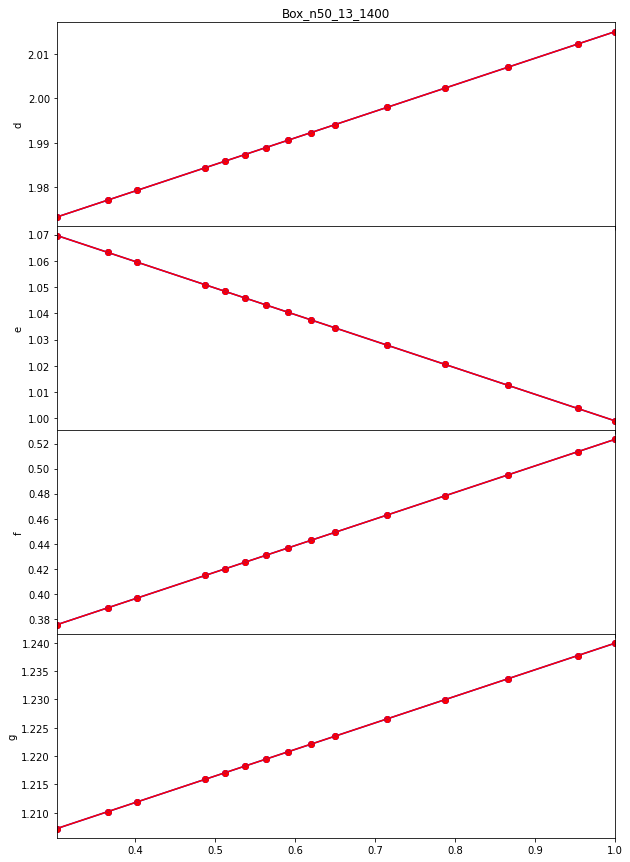

 28%|██▊       | 14/50 [00:07<00:17,  2.11it/s]

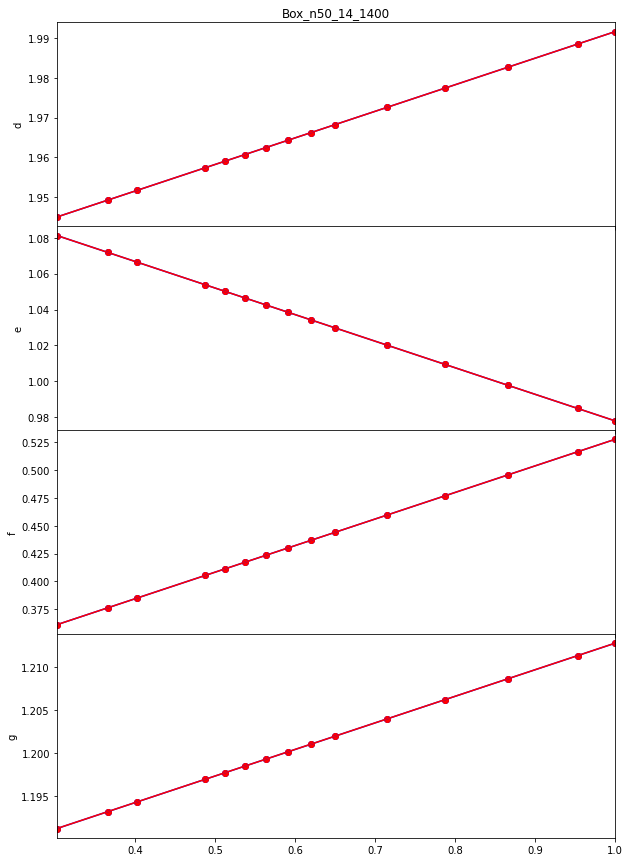

 30%|███       | 15/50 [00:08<00:16,  2.18it/s]

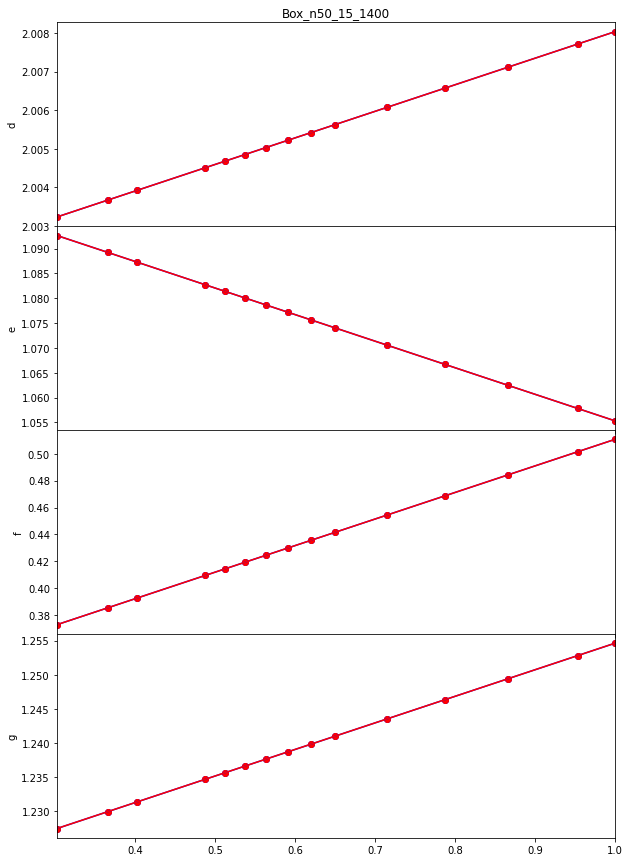

 32%|███▏      | 16/50 [00:08<00:15,  2.15it/s]

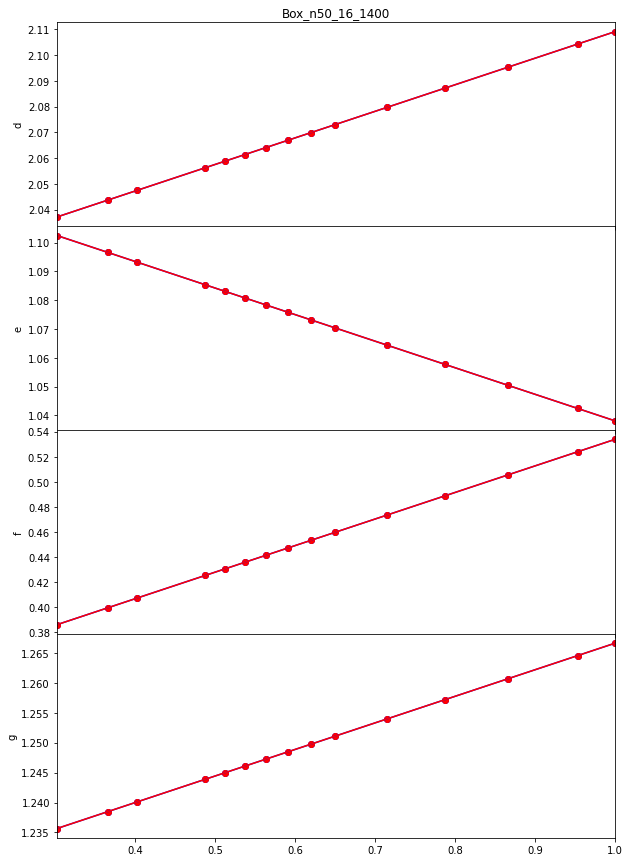

 34%|███▍      | 17/50 [00:09<00:17,  1.84it/s]

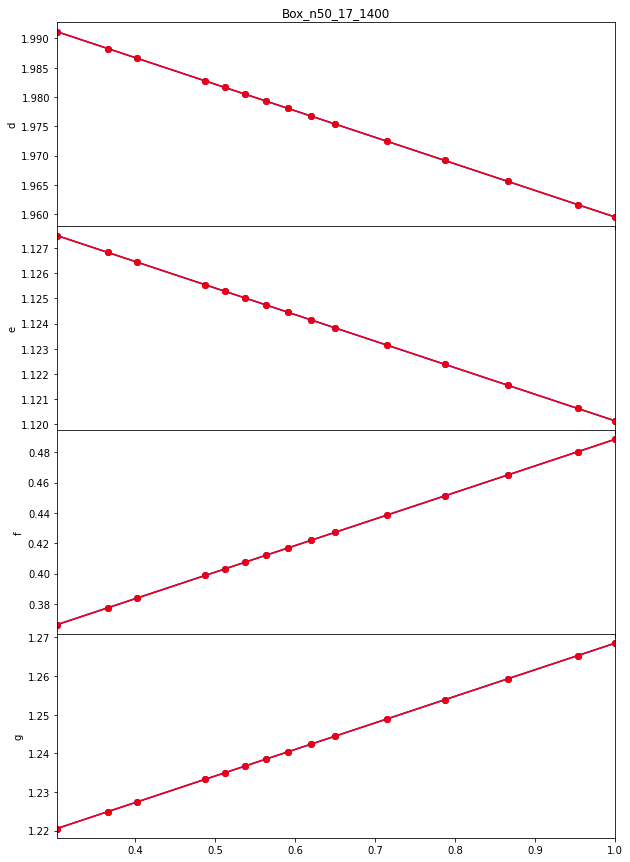

 36%|███▌      | 18/50 [00:10<00:19,  1.67it/s]

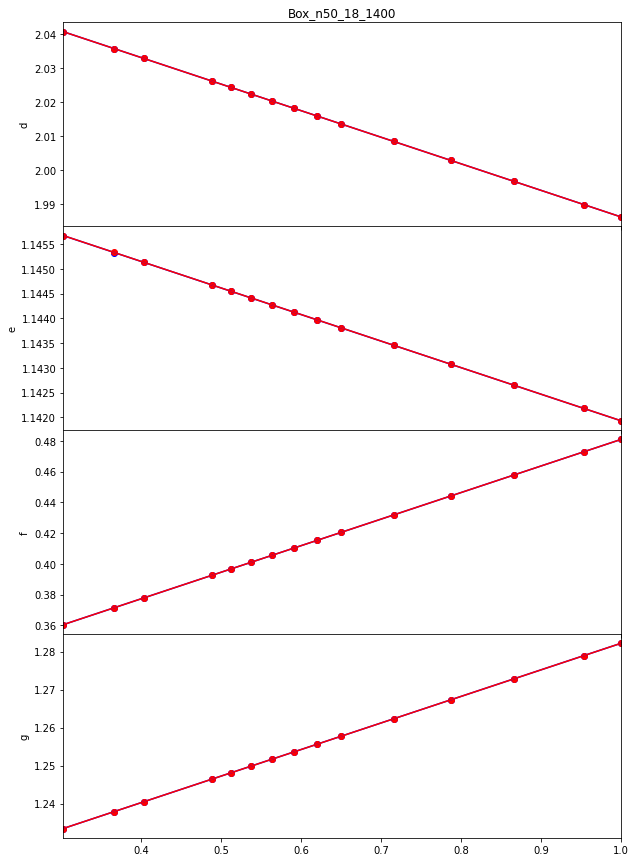

 38%|███▊      | 19/50 [00:10<00:18,  1.65it/s]

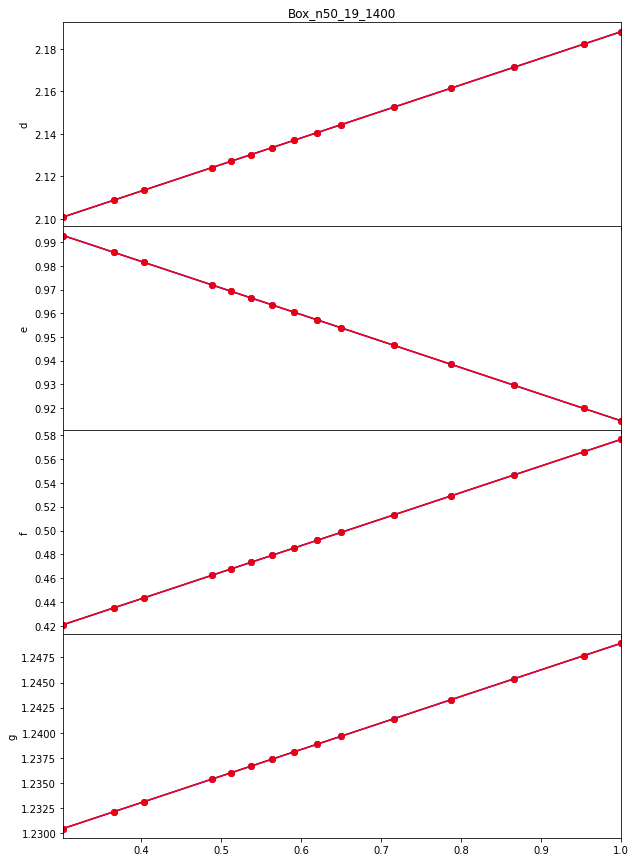

 40%|████      | 20/50 [00:11<00:16,  1.77it/s]

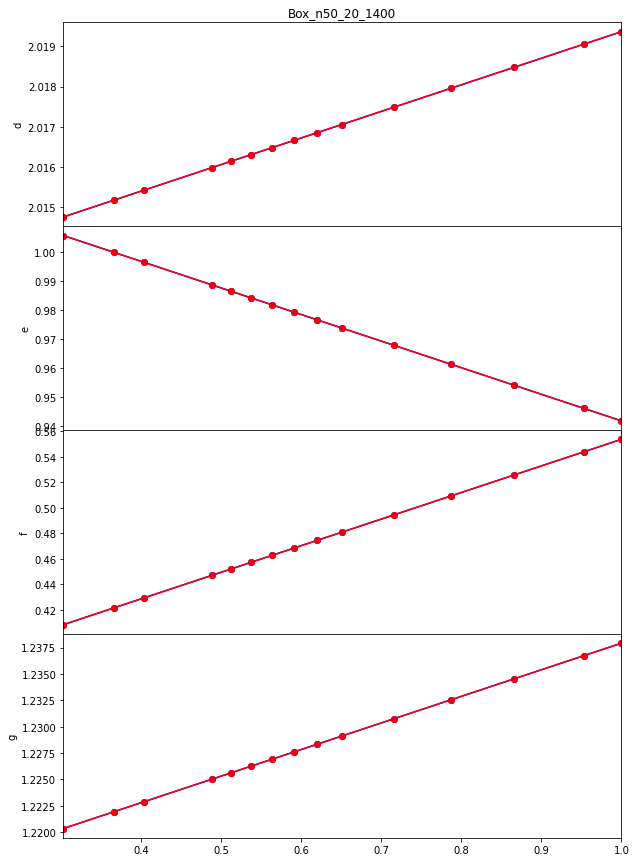

 42%|████▏     | 21/50 [00:11<00:15,  1.89it/s]

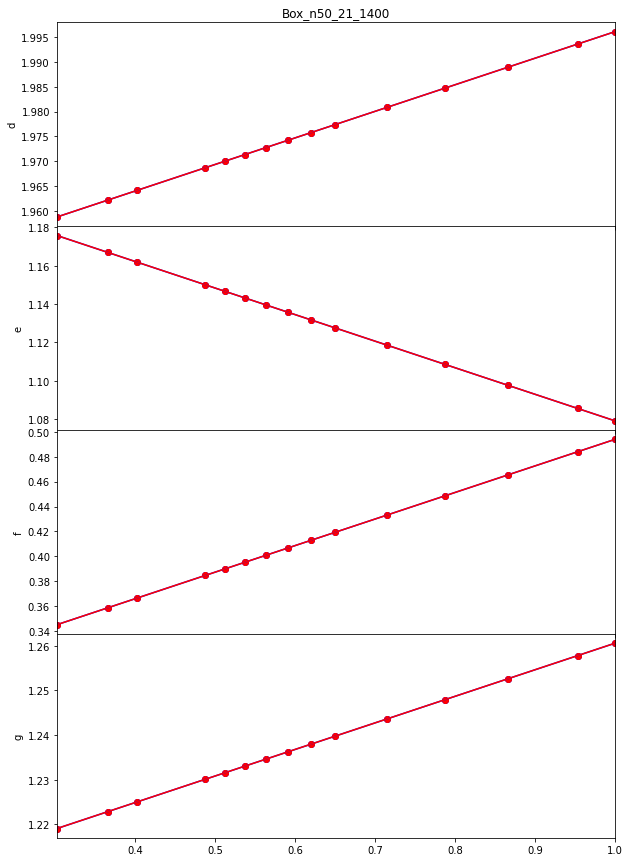

 44%|████▍     | 22/50 [00:12<00:16,  1.68it/s]

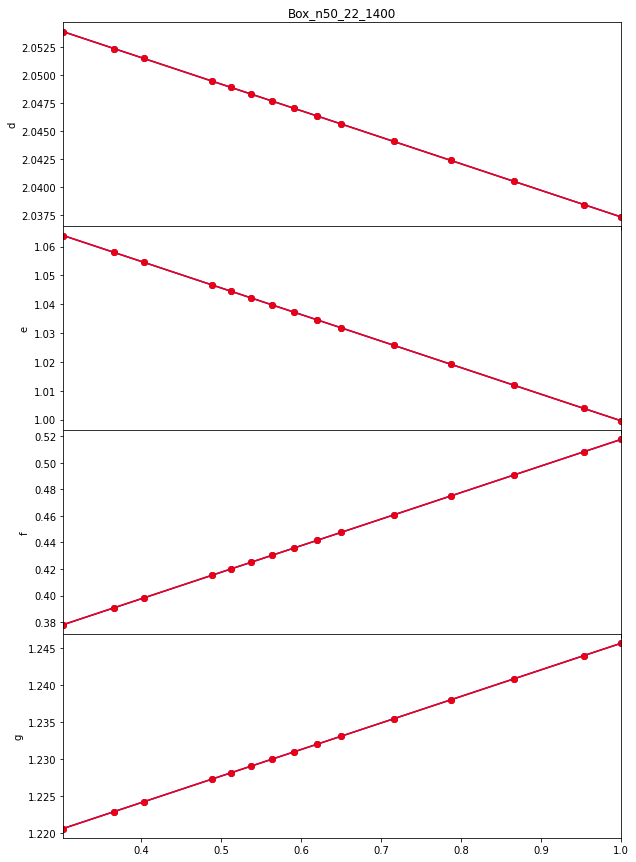

 46%|████▌     | 23/50 [00:12<00:15,  1.70it/s]

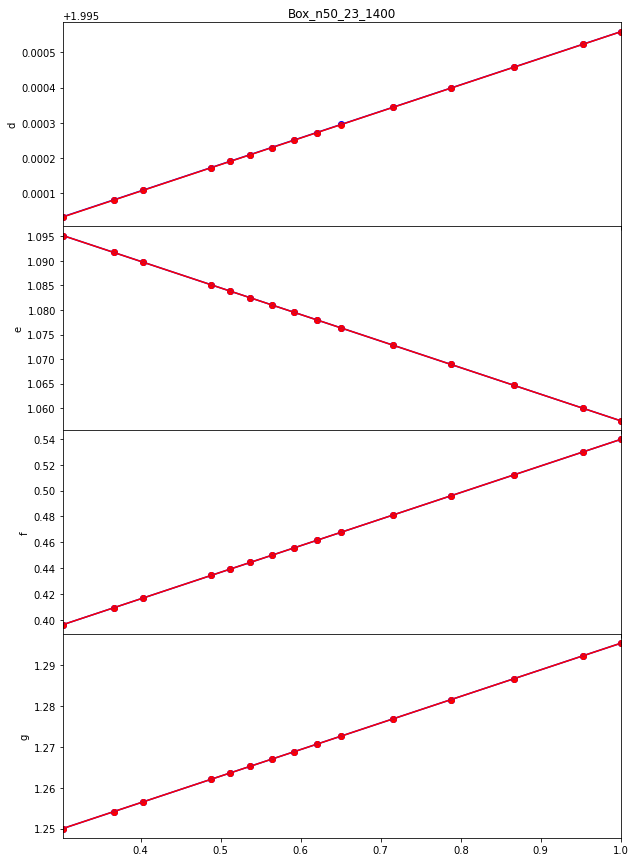

 48%|████▊     | 24/50 [00:13<00:15,  1.64it/s]

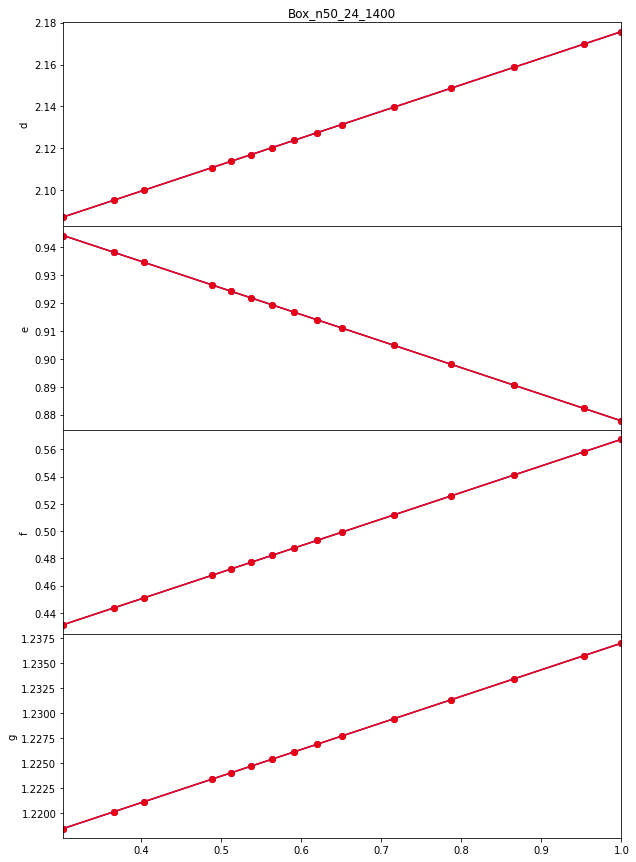

 50%|█████     | 25/50 [00:14<00:14,  1.78it/s]

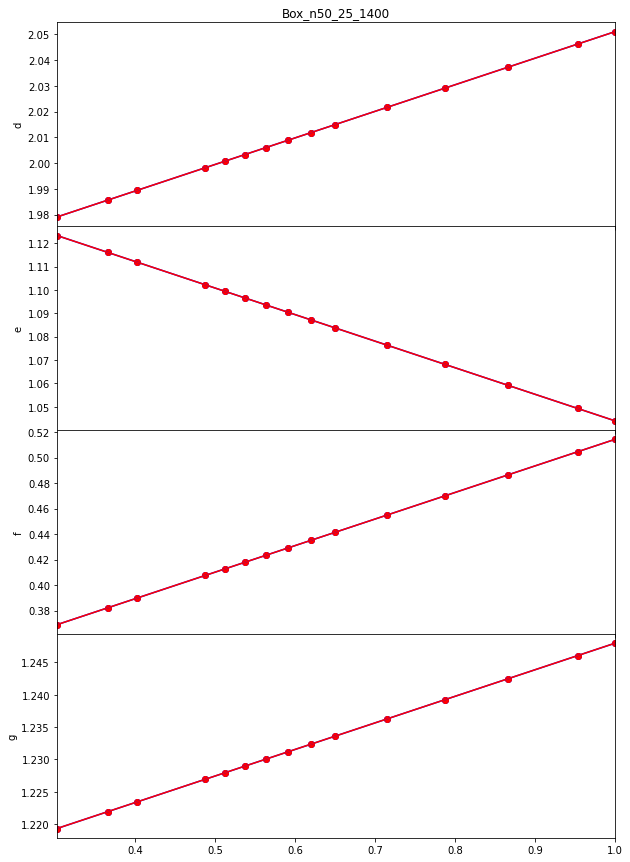

 52%|█████▏    | 26/50 [00:14<00:13,  1.73it/s]

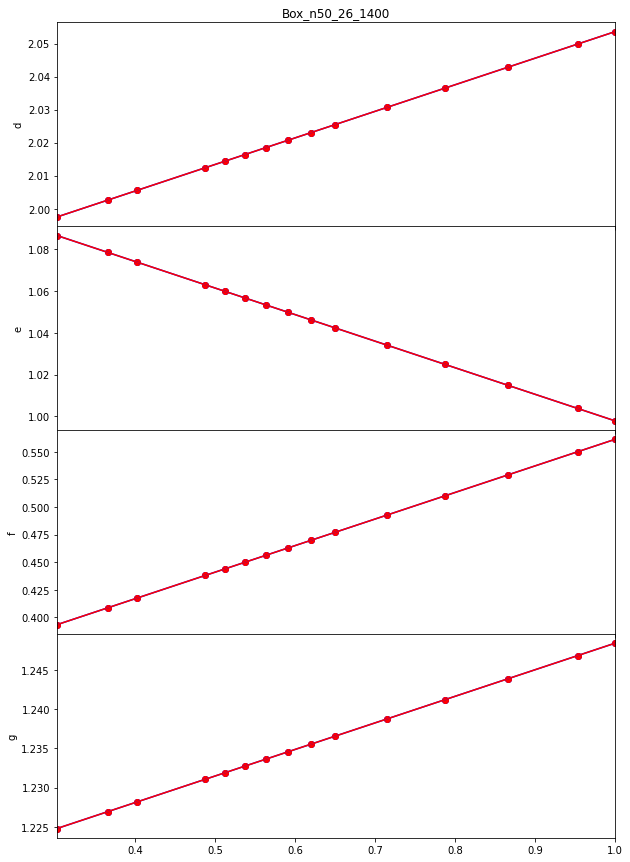

 54%|█████▍    | 27/50 [00:15<00:13,  1.76it/s]

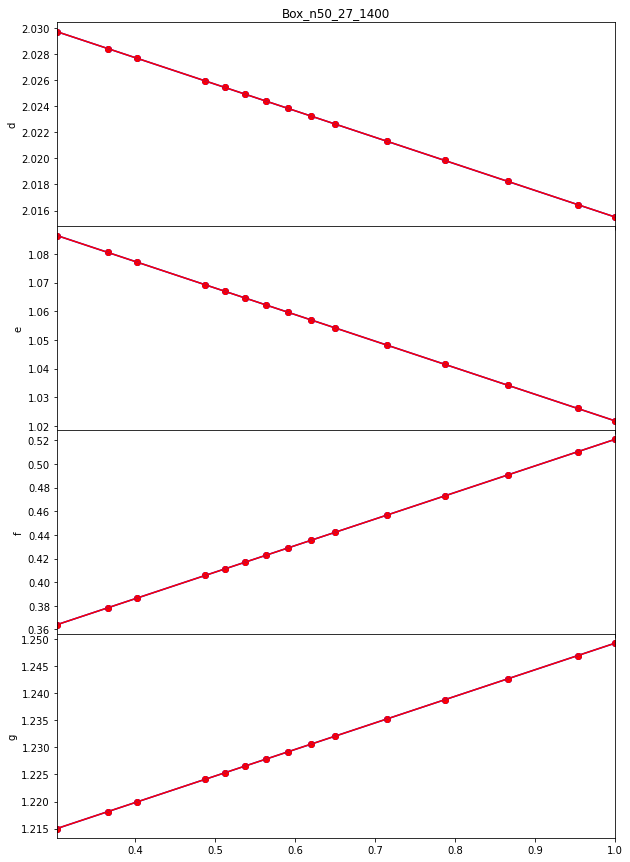

 56%|█████▌    | 28/50 [00:15<00:12,  1.83it/s]

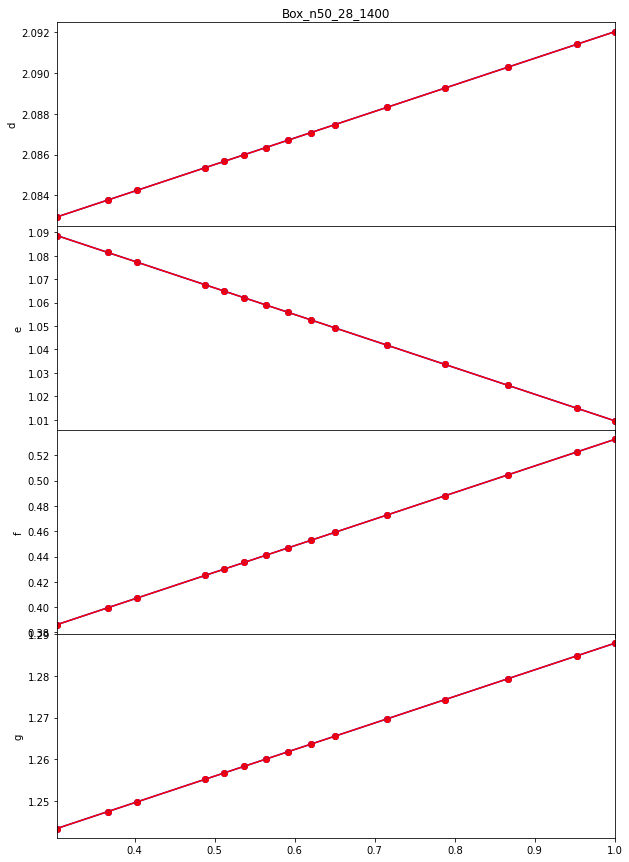

 58%|█████▊    | 29/50 [00:16<00:10,  1.96it/s]

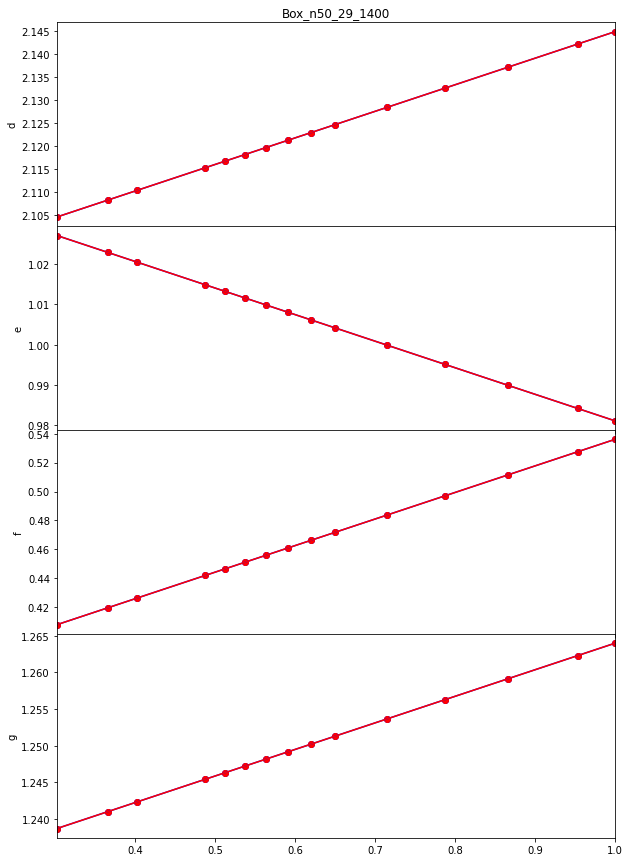

 60%|██████    | 30/50 [00:16<00:10,  1.82it/s]

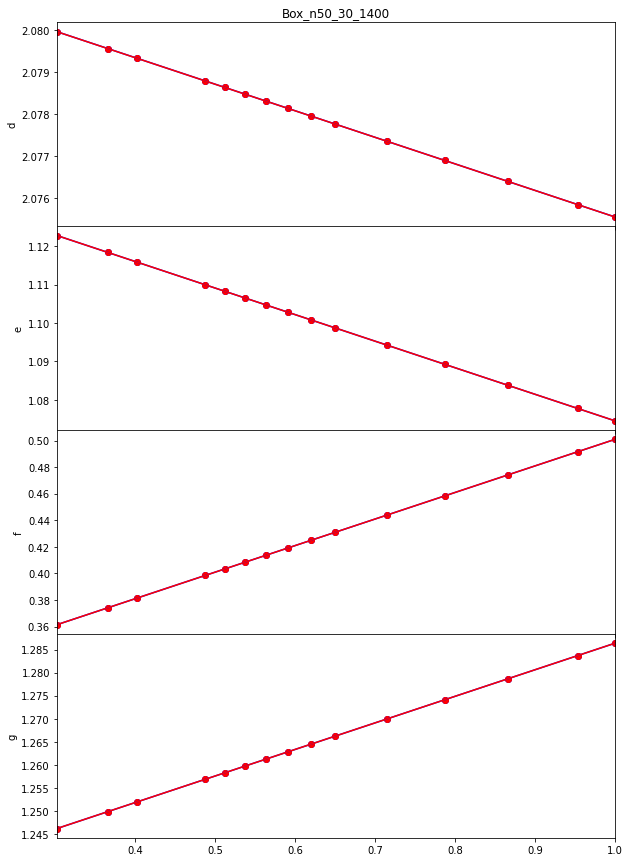

 62%|██████▏   | 31/50 [00:17<00:10,  1.90it/s]

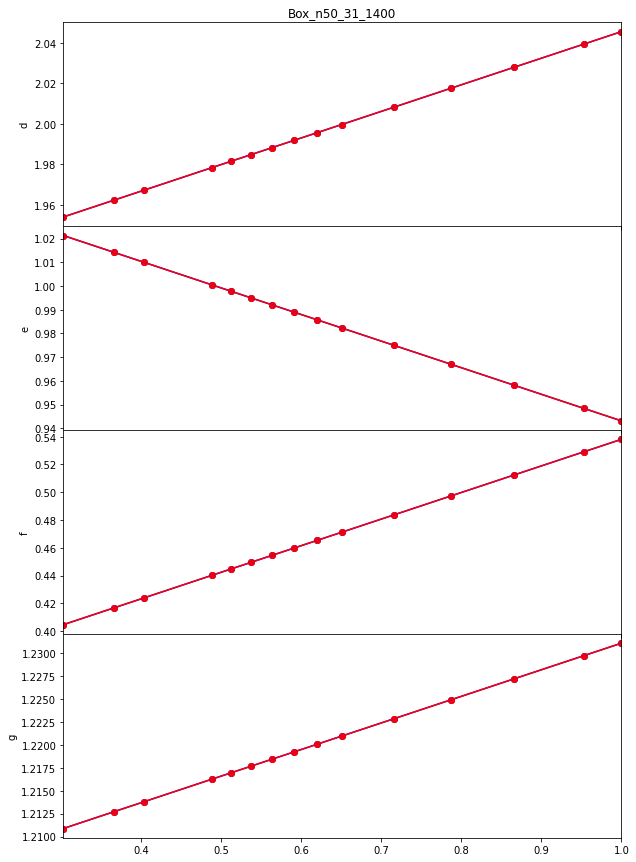

 64%|██████▍   | 32/50 [00:17<00:09,  1.82it/s]

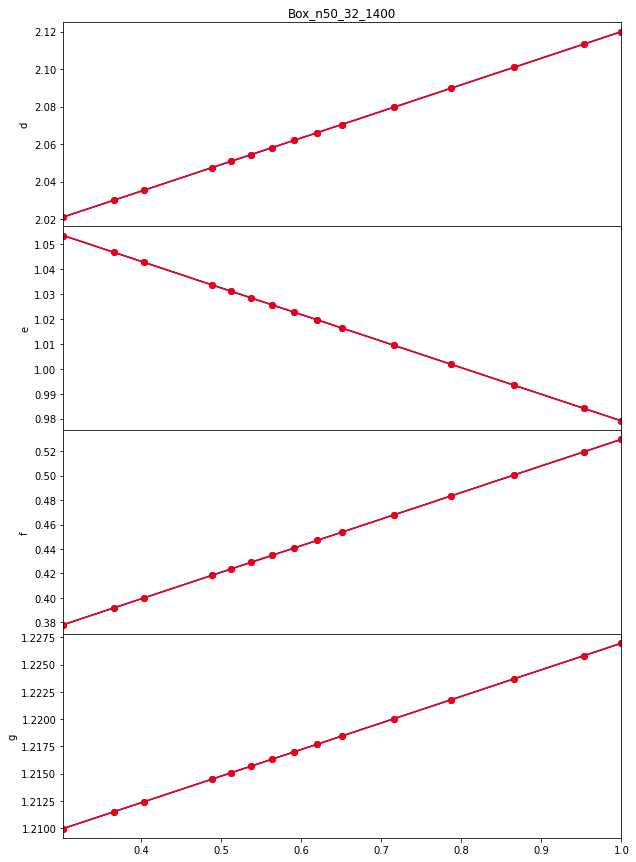

 66%|██████▌   | 33/50 [00:18<00:08,  1.91it/s]

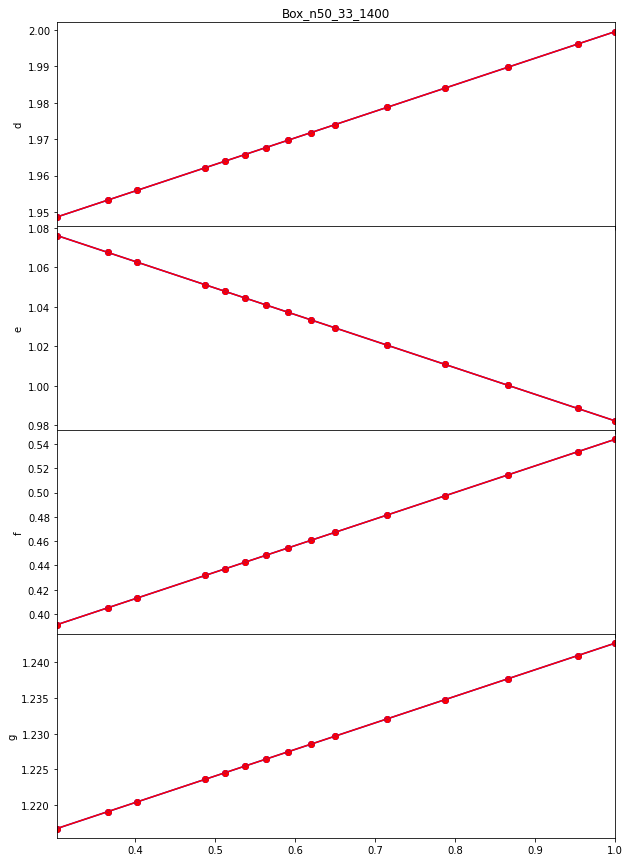

 68%|██████▊   | 34/50 [00:18<00:07,  2.03it/s]

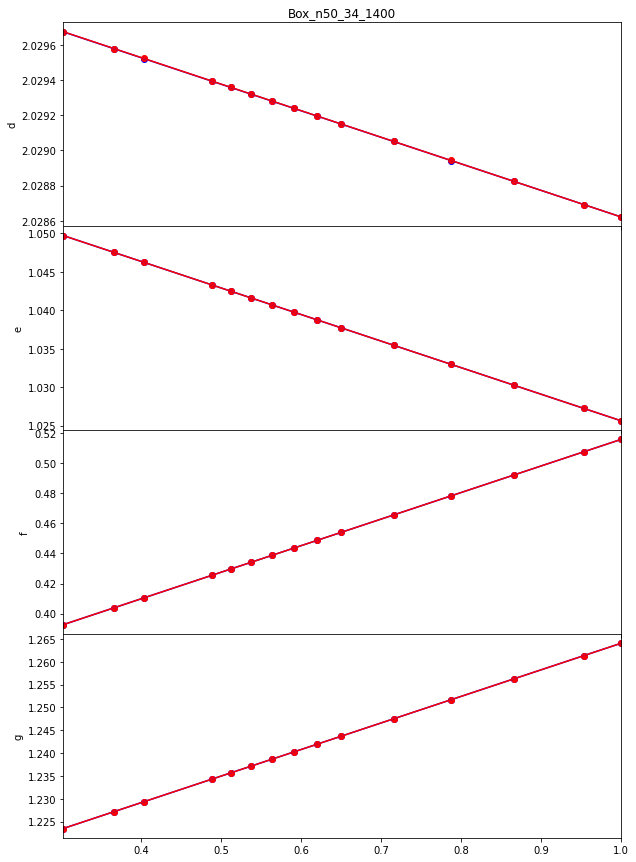

 70%|███████   | 35/50 [00:19<00:07,  1.93it/s]

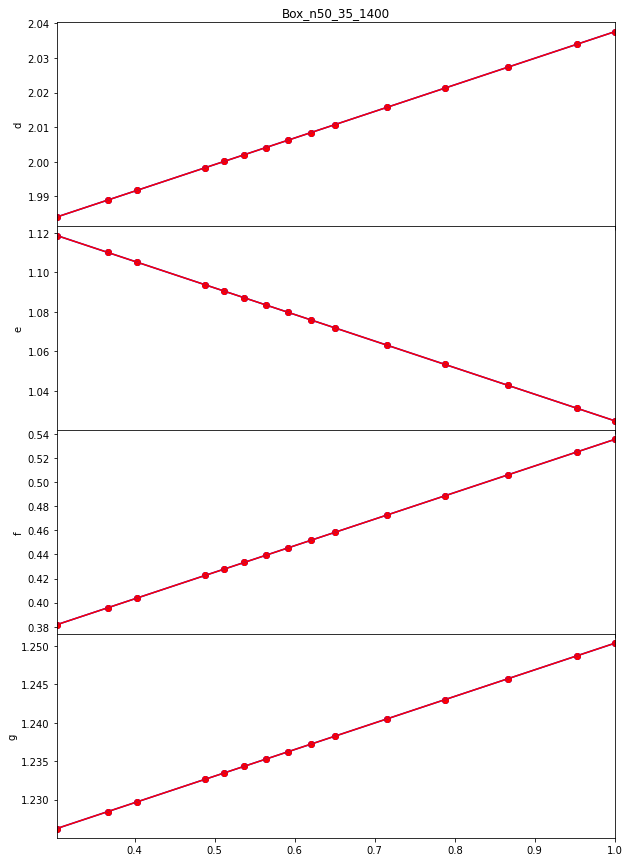

 72%|███████▏  | 36/50 [00:19<00:07,  1.94it/s]

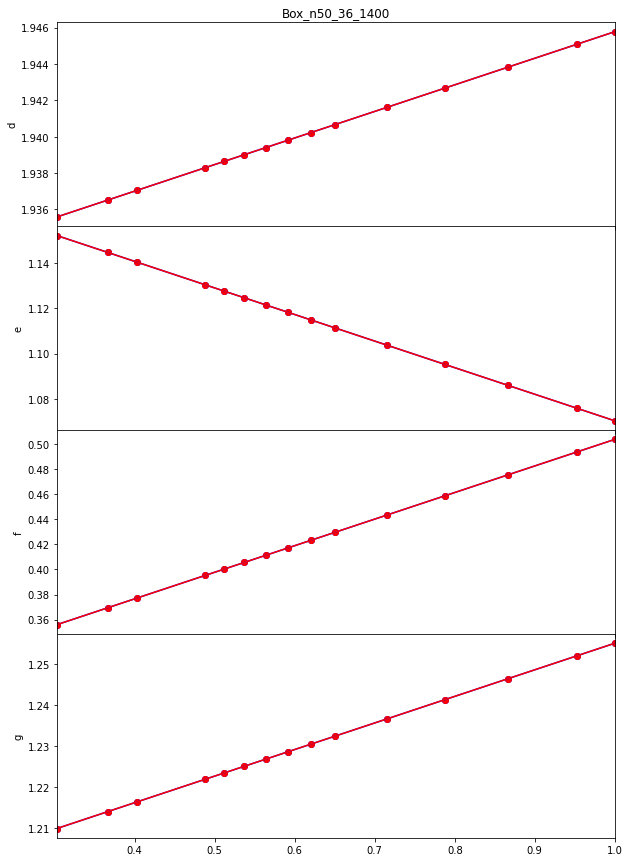

 74%|███████▍  | 37/50 [00:20<00:06,  2.06it/s]

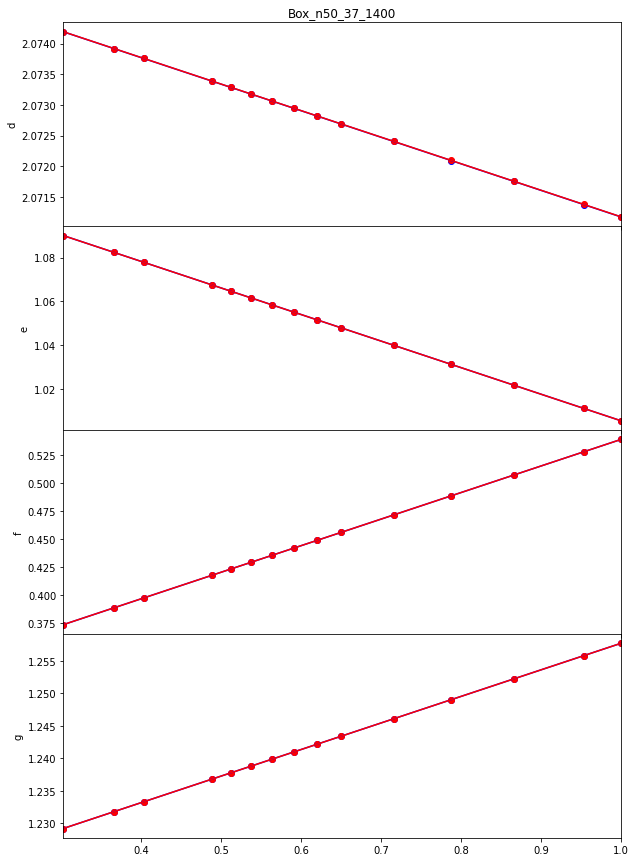

 76%|███████▌  | 38/50 [00:20<00:05,  2.07it/s]

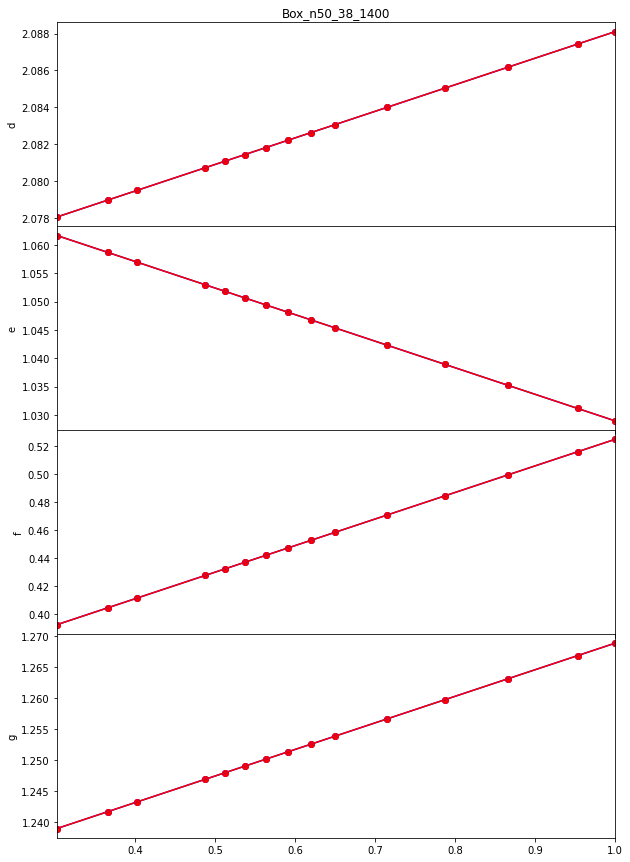

 78%|███████▊  | 39/50 [00:21<00:05,  2.04it/s]

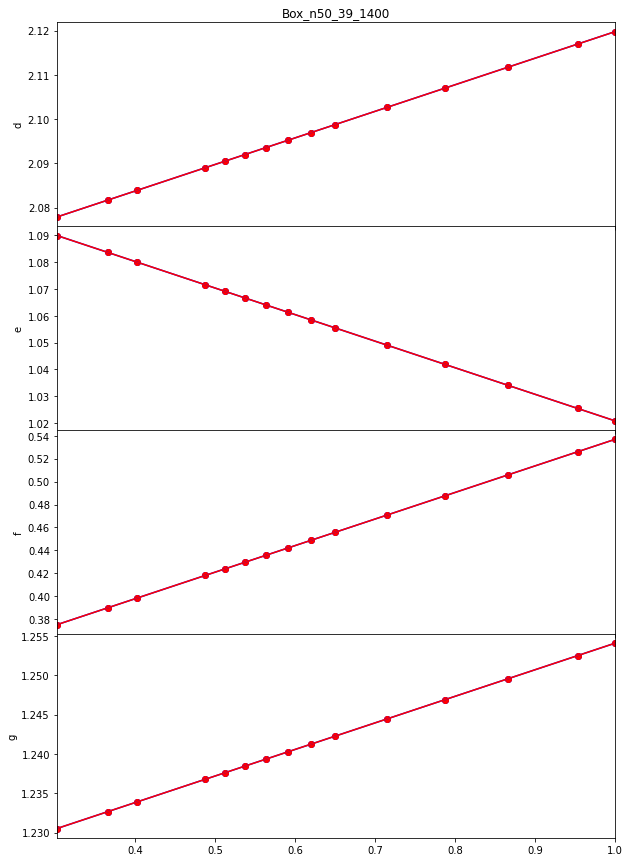

 80%|████████  | 40/50 [00:21<00:04,  2.13it/s]

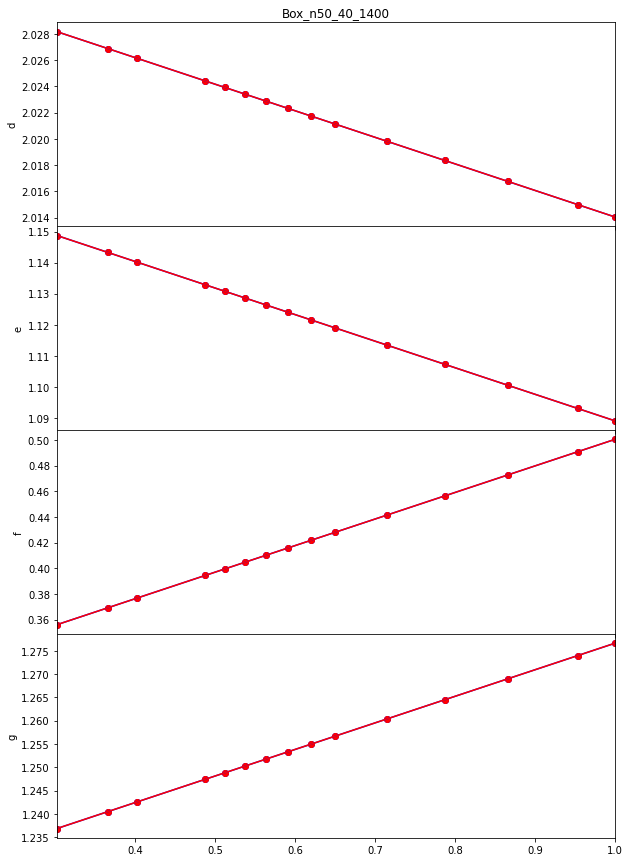

 82%|████████▏ | 41/50 [00:22<00:05,  1.68it/s]

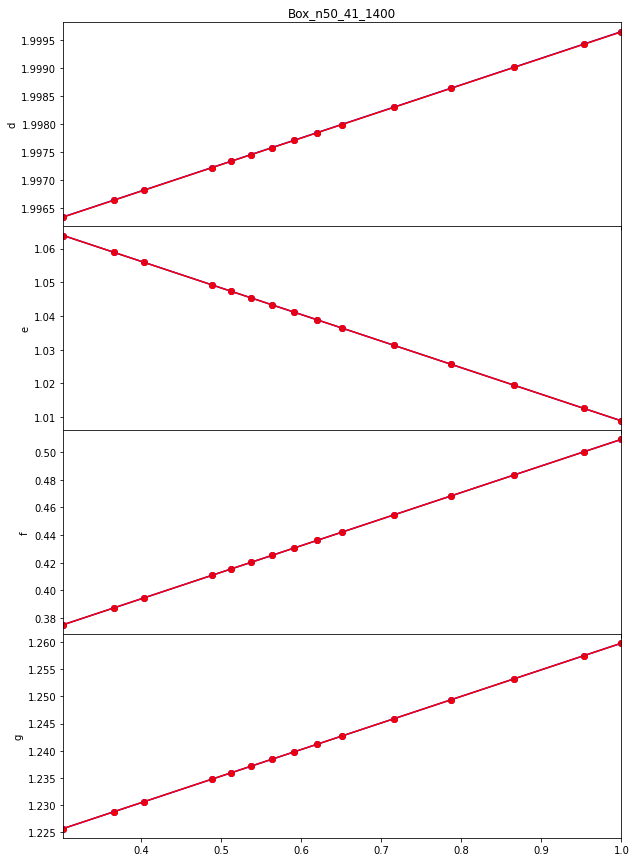

 84%|████████▍ | 42/50 [00:23<00:05,  1.59it/s]

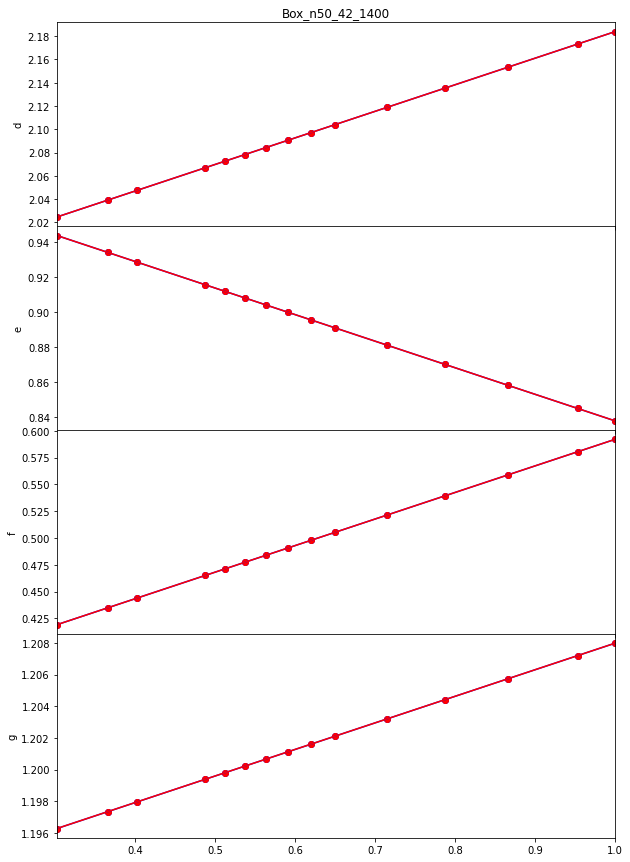

 86%|████████▌ | 43/50 [00:23<00:04,  1.69it/s]

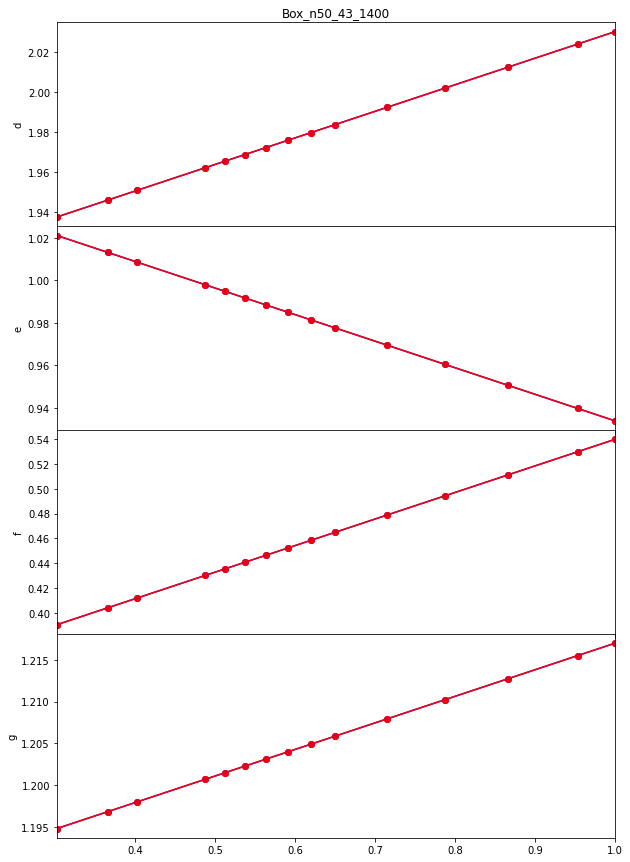

 88%|████████▊ | 44/50 [00:24<00:03,  1.76it/s]

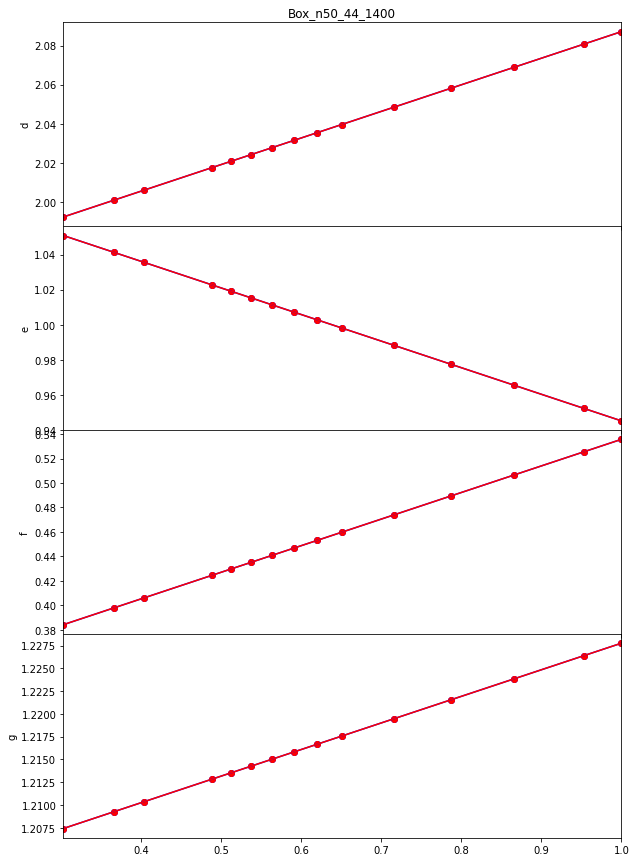

 90%|█████████ | 45/50 [00:24<00:02,  1.78it/s]

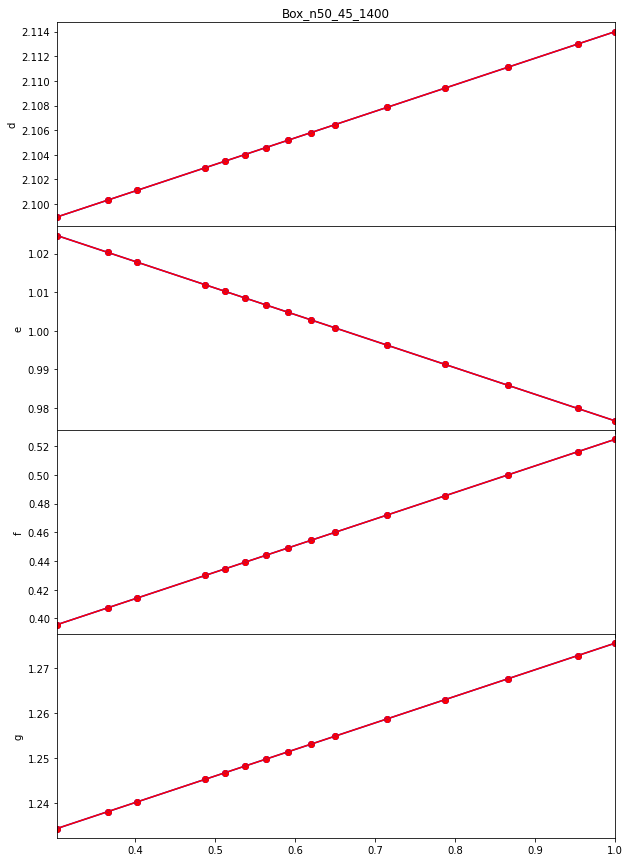

 92%|█████████▏| 46/50 [00:25<00:02,  1.78it/s]

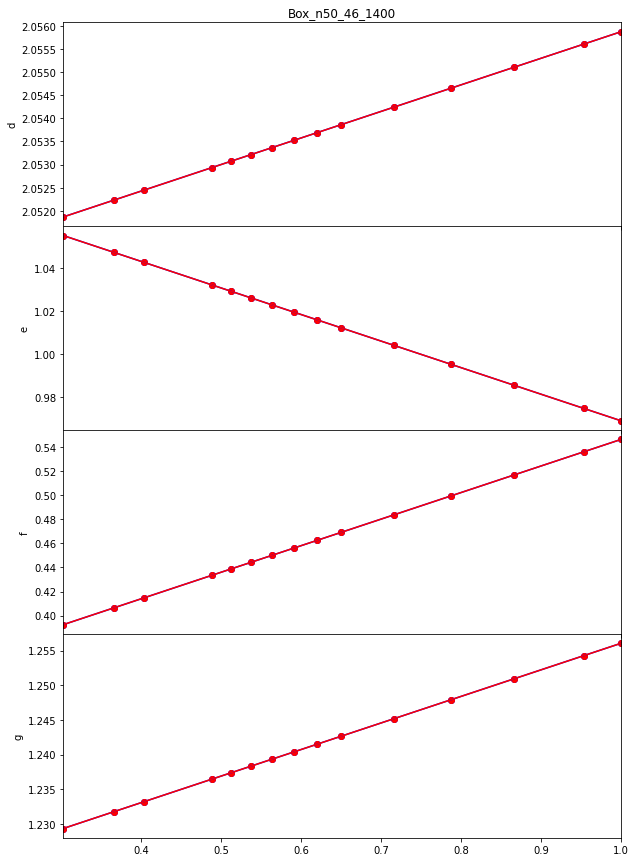

 94%|█████████▍| 47/50 [00:25<00:01,  1.90it/s]

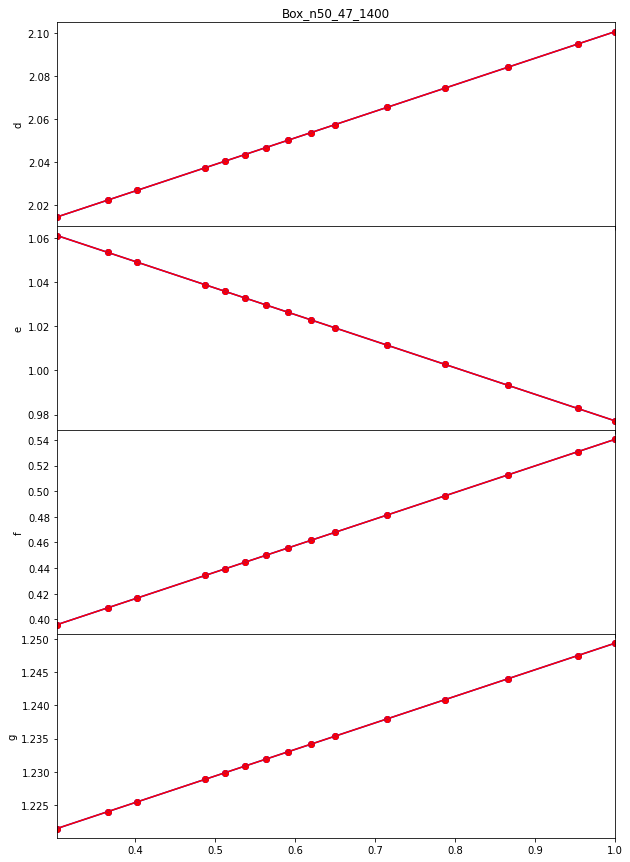

 96%|█████████▌| 48/50 [00:26<00:01,  1.97it/s]

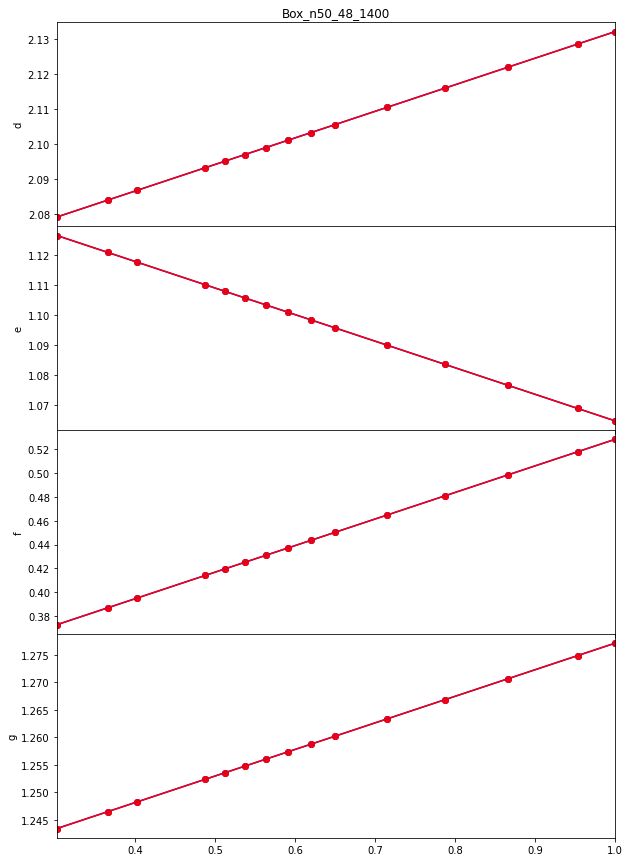

 98%|█████████▊| 49/50 [00:26<00:00,  2.09it/s]

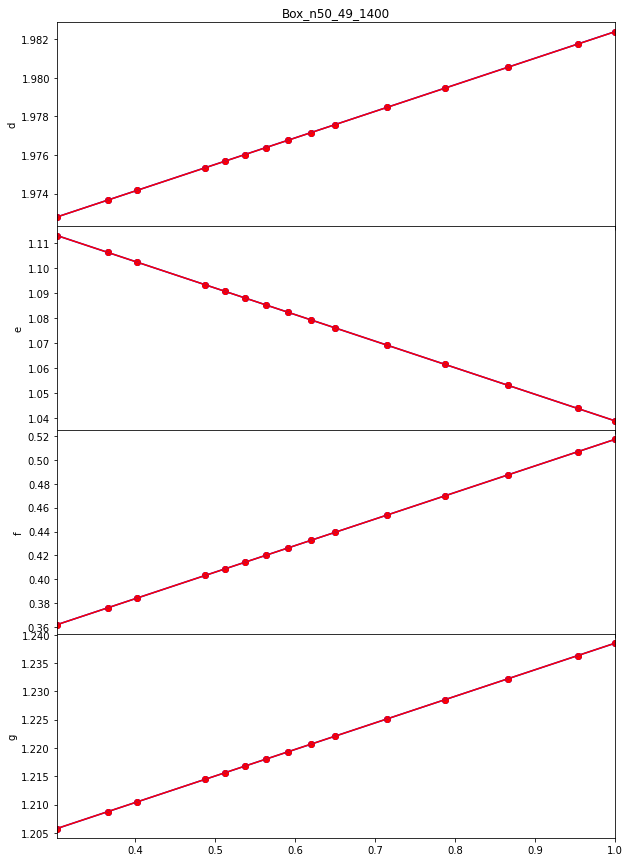

100%|██████████| 50/50 [00:27<00:00,  1.83it/s]


In [14]:

import matplotlib.pyplot as plt


wjat = ['Box_n50_0_1400', 'Box_n50_14_1400', 'Box_n50_33_1400', 'Box_n50_32_1400']
wjat=['Box_n50_14_1400',]
wjat = ['Box_n50_%d_1400'%i for i in range(50)]
# wjat = [leave_out_box, 'Box98_1400']

# for box in [leave_out_box]:#, 'Box_n50_14_1400']:
# for box in [leave_out_box, 'Box98_1400', 'Box_n50_0_1400']:#, 'Box_n50_14_1400', 'Box_n50_33_1400', 'Box_n50_32_1400']:
for box in tqdm(wjat):
    fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(10,15), sharex=True)
    curr_cosmo_vals = tuple(get_cosmo_vals(cosmo_params[box]))
    curr_ccl_cosmo = get_ccl_cosmology(curr_cosmo_vals)

    param_names = ['d','e','f','g']
    ndim = len(param_names)
    plt.subplots_adjust(wspace=0, hspace=0)

    params = {'d':[], 'e':[], 'f':[], 'g':[]}
    paramsEMU = {'d':[], 'e':[], 'f':[], 'g':[]}

    for a in a_list:
        R = 8 / (cosmo_params[box]['H0'] / 100)
        sigma8z = cosmo.sigmaR(R, a=a)
        EMU  = (Emulator.predict_params(cosmo_params[box], scaleToRedshift(a))) #, sigma8z))

        with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_params.pkl"%(box), "rb") as f:
            MLE_params = pickle.load(f)
            curr_params = list(MLE_params.values())
            paired_params = list(zip(curr_params, curr_params[1:]))[::2]

            param_at_z = {'d':-1, 'e':-1, 'f':-1, 'g':-1}

            for (p0,p1), key in zip(paired_params, param_at_z):
                param_at_z[key] = p(p0, p1, a)
            MLE_params = param_at_z

        for key in MLE_params:
            params[key] += [MLE_params[key]]
            paramsEMU[key] += [EMU[key]]


    for i, param in enumerate(params):
        aaaaa = 1
        axs[i].scatter(a_list, params[param], alpha=aaaaa, color='blue')
#         print(list(zip(a_list,params[param])))
#         print()
        axs[i].plot(a_list, params[param], alpha=aaaaa, color='blue')

        axs[i].scatter(a_list, paramsEMU[param], alpha=aaaaa, color='red')
        axs[i].plot(a_list, paramsEMU[param], alpha=aaaaa, color='red')

        axs[i].set_ylabel(param)
    #     axs[i].set_ylim([0,2])
        axs[i].set_xlim([min(a_list), 1])
    axs[0].set_title(box)
    plt.show()
    axs[-1].set_xlabel('a')
    # axs[0].set_ylim([0.25,.45])
    # axs[1].set_ylim([0.29,.305])
    # axs[2].set_ylim([1.4,1.8])
    # axs[3].set_ylim([1.18, 1.2])
    axs[0].set_ylim([1.7, 3.])
    axs[1].set_ylim([0.9, 1.1])
    axs[2].set_ylim([.3,.6])
    axs[3].set_ylim([1.2,1.3])
    # axs[0].set_title(box)

  7%|▋         | 1/15 [00:00<00:13,  1.00it/s]

[1.9635033183484323, 0.06697976643755499, 1.0401751173909572, -0.14822584234049754, 0.427415309014025, 0.23885547147971156, 1.199831477314671, 0.030923137061695423]


 20%|██        | 3/15 [00:01<00:04,  2.72it/s]

[1.9635033183484323, 0.06697976643755499, 1.0401751173909572, -0.14822584234049754, 0.427415309014025, 0.23885547147971156, 1.199831477314671, 0.030923137061695423]
[1.9635033183484323, 0.06697976643755499, 1.0401751173909572, -0.14822584234049754, 0.427415309014025, 0.23885547147971156, 1.199831477314671, 0.030923137061695423]


 33%|███▎      | 5/15 [00:01<00:02,  4.60it/s]

[1.9635033183484323, 0.06697976643755499, 1.0401751173909572, -0.14822584234049754, 0.427415309014025, 0.23885547147971156, 1.199831477314671, 0.030923137061695423]
[1.9635033183484323, 0.06697976643755499, 1.0401751173909572, -0.14822584234049754, 0.427415309014025, 0.23885547147971156, 1.199831477314671, 0.030923137061695423]


 47%|████▋     | 7/15 [00:01<00:01,  6.19it/s]

[1.9635033183484323, 0.06697976643755499, 1.0401751173909572, -0.14822584234049754, 0.427415309014025, 0.23885547147971156, 1.199831477314671, 0.030923137061695423]
[1.9635033183484323, 0.06697976643755499, 1.0401751173909572, -0.14822584234049754, 0.427415309014025, 0.23885547147971156, 1.199831477314671, 0.030923137061695423]


 60%|██████    | 9/15 [00:02<00:00,  7.37it/s]

[1.9635033183484323, 0.06697976643755499, 1.0401751173909572, -0.14822584234049754, 0.427415309014025, 0.23885547147971156, 1.199831477314671, 0.030923137061695423]
[1.9635033183484323, 0.06697976643755499, 1.0401751173909572, -0.14822584234049754, 0.427415309014025, 0.23885547147971156, 1.199831477314671, 0.030923137061695423]
[1.9635033183484323, 0.06697976643755499, 1.0401751173909572, -0.14822584234049754, 0.427415309014025, 0.23885547147971156, 1.199831477314671, 0.030923137061695423]


 80%|████████  | 12/15 [00:02<00:00,  7.09it/s]

[1.9635033183484323, 0.06697976643755499, 1.0401751173909572, -0.14822584234049754, 0.427415309014025, 0.23885547147971156, 1.199831477314671, 0.030923137061695423]
[1.9635033183484323, 0.06697976643755499, 1.0401751173909572, -0.14822584234049754, 0.427415309014025, 0.23885547147971156, 1.199831477314671, 0.030923137061695423]


 93%|█████████▎| 14/15 [00:02<00:00,  8.54it/s]

[1.9635033183484323, 0.06697976643755499, 1.0401751173909572, -0.14822584234049754, 0.427415309014025, 0.23885547147971156, 1.199831477314671, 0.030923137061695423]
[1.9635033183484323, 0.06697976643755499, 1.0401751173909572, -0.14822584234049754, 0.427415309014025, 0.23885547147971156, 1.199831477314671, 0.030923137061695423]
[1.9635033183484323, 0.06697976643755499, 1.0401751173909572, -0.14822584234049754, 0.427415309014025, 0.23885547147971156, 1.199831477314671, 0.030923137061695423]


100%|██████████| 15/15 [00:02<00:00,  5.28it/s]


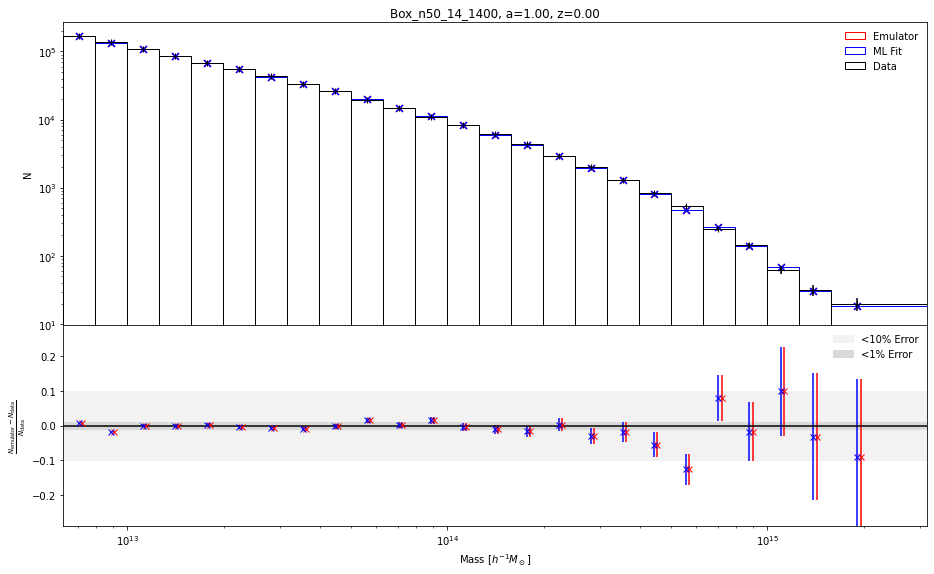

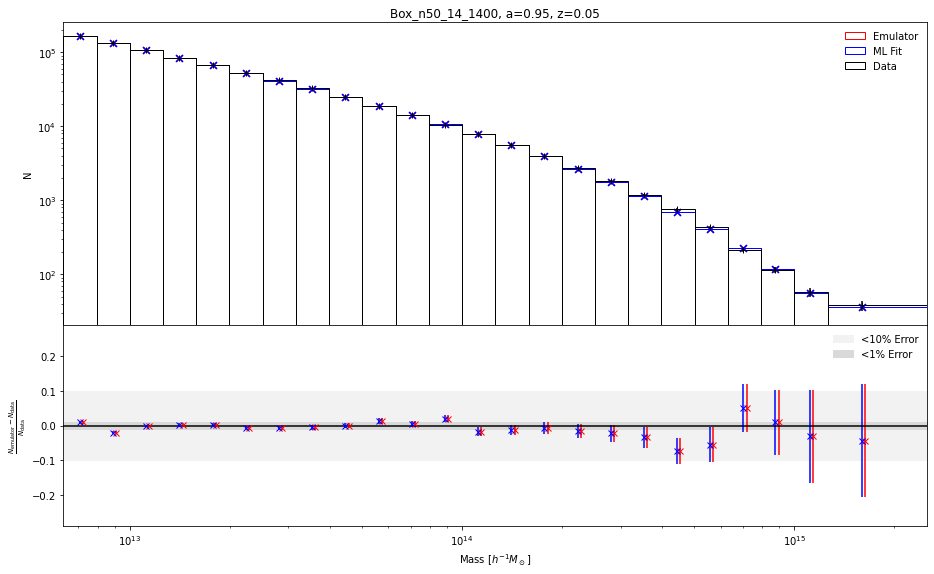

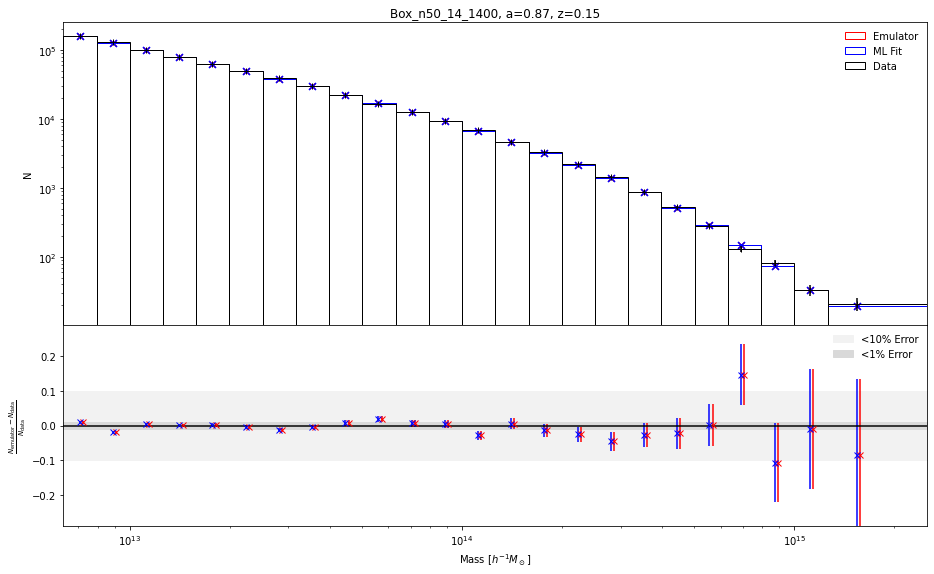

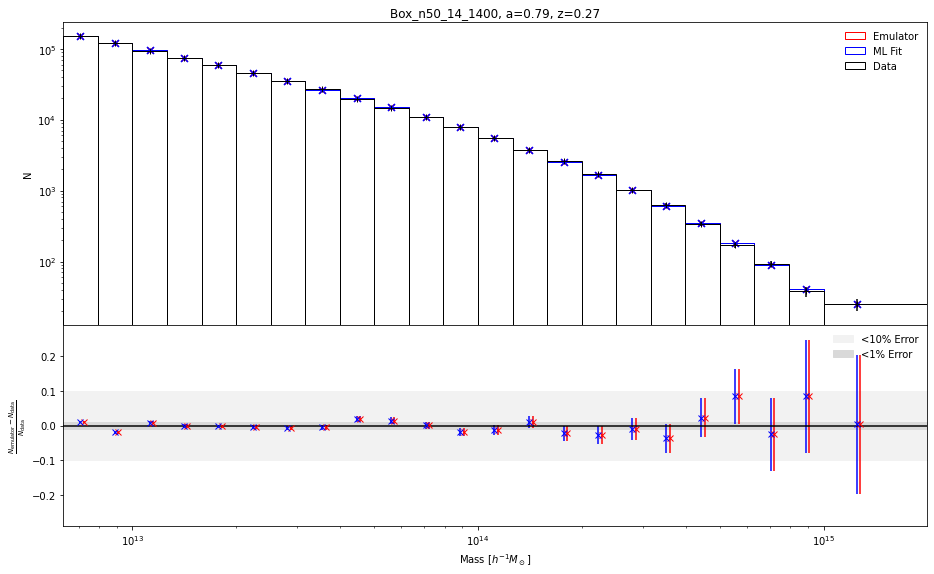

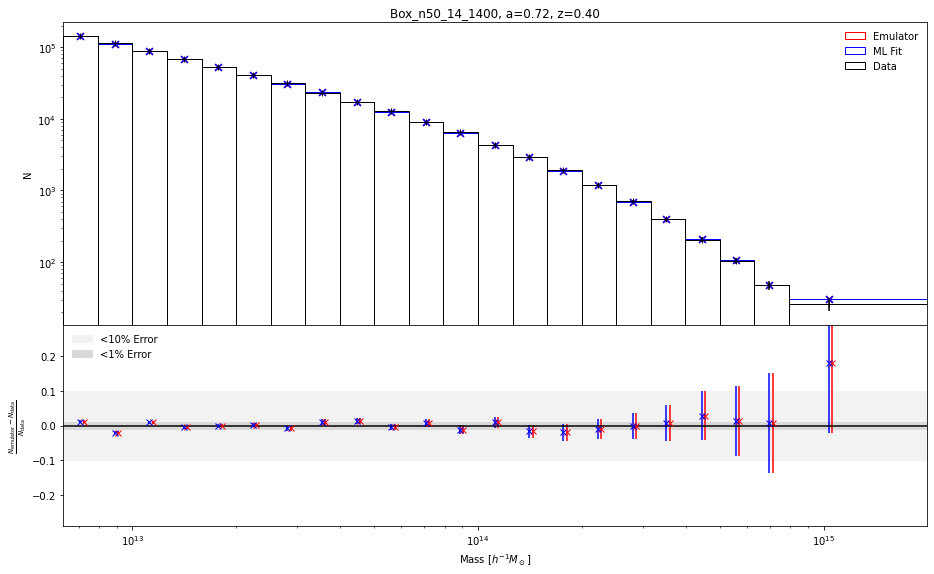

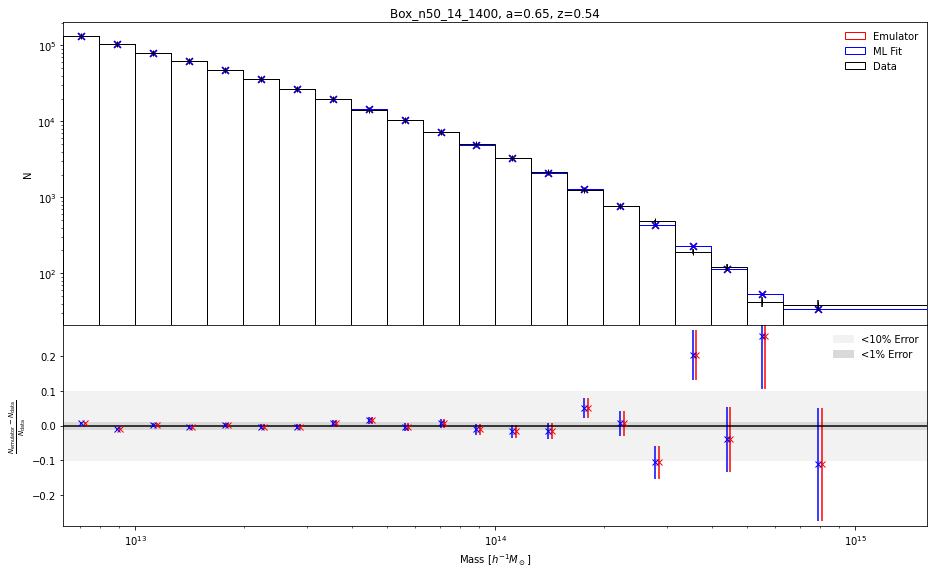

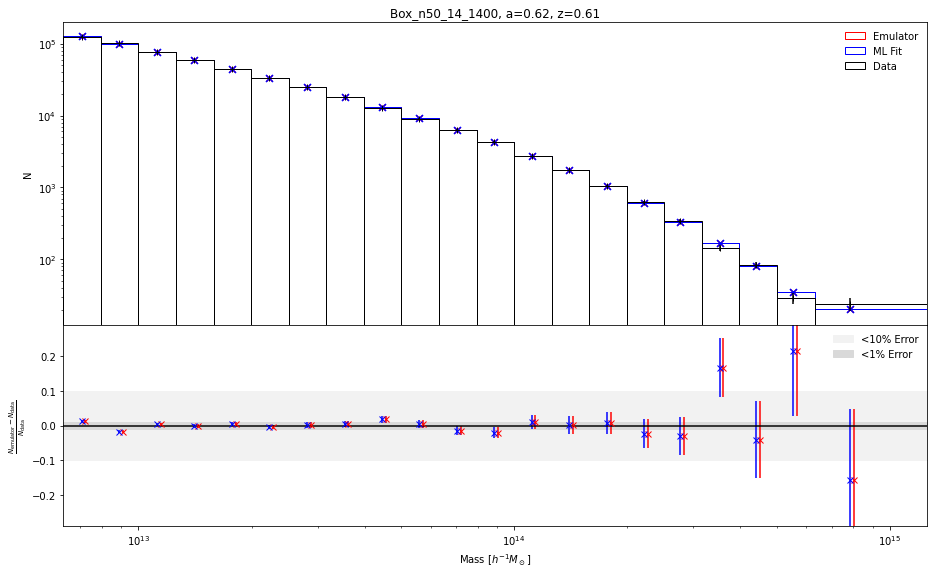

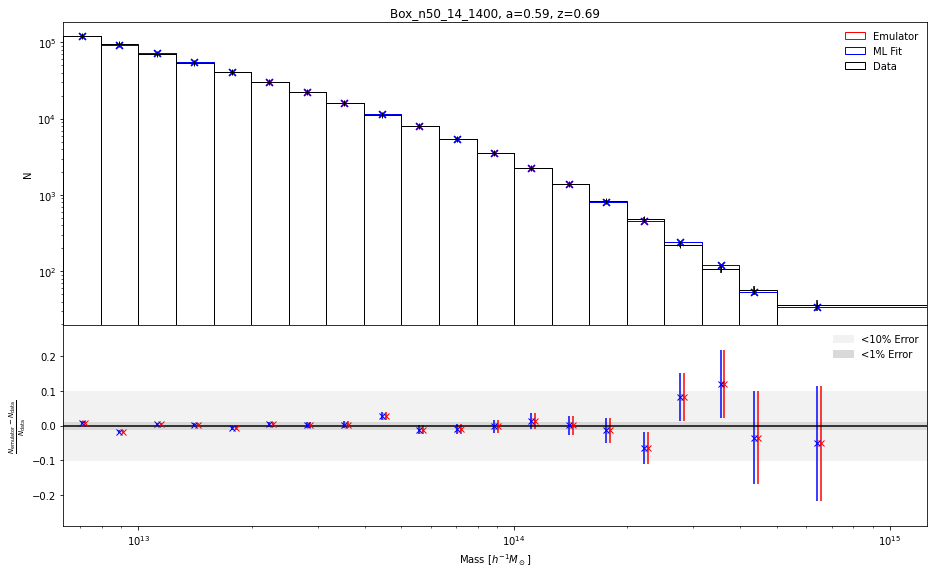

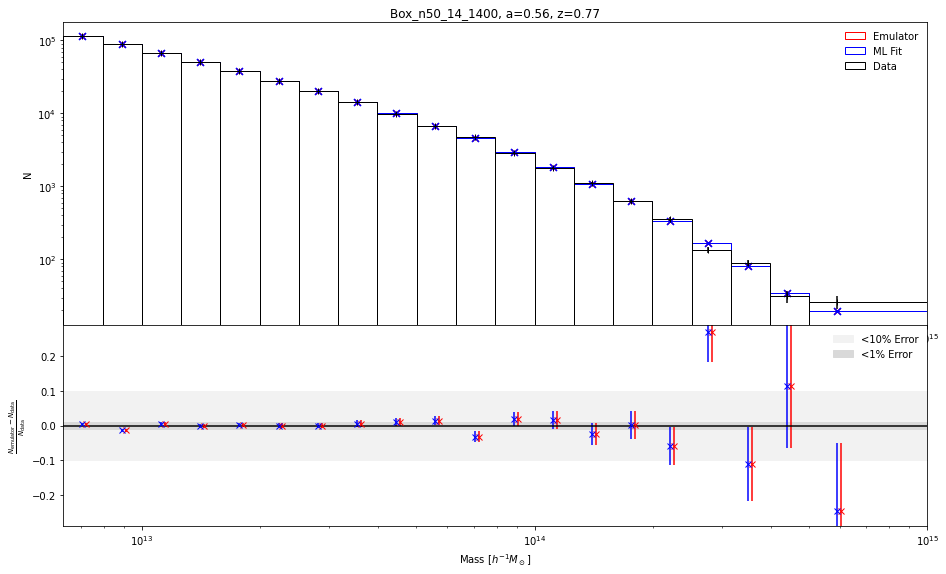

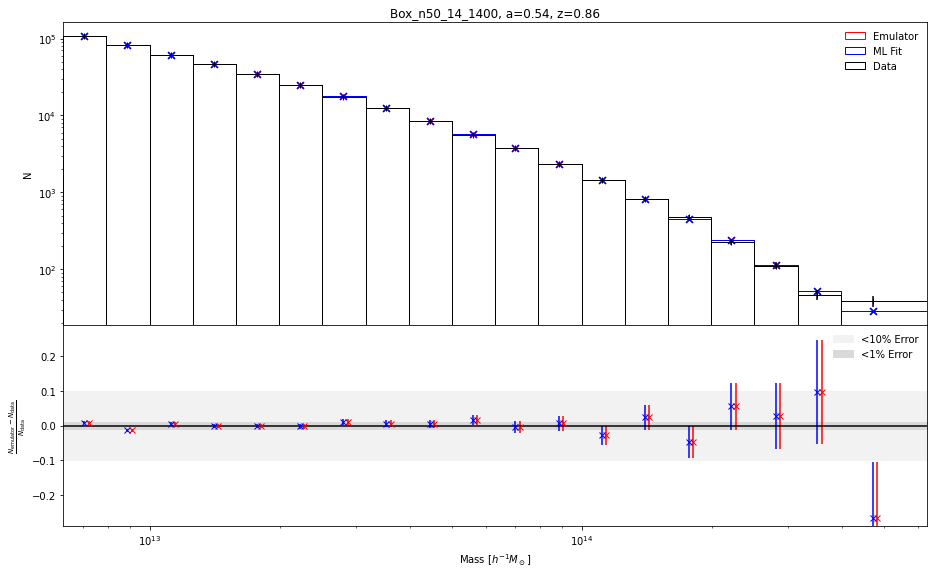

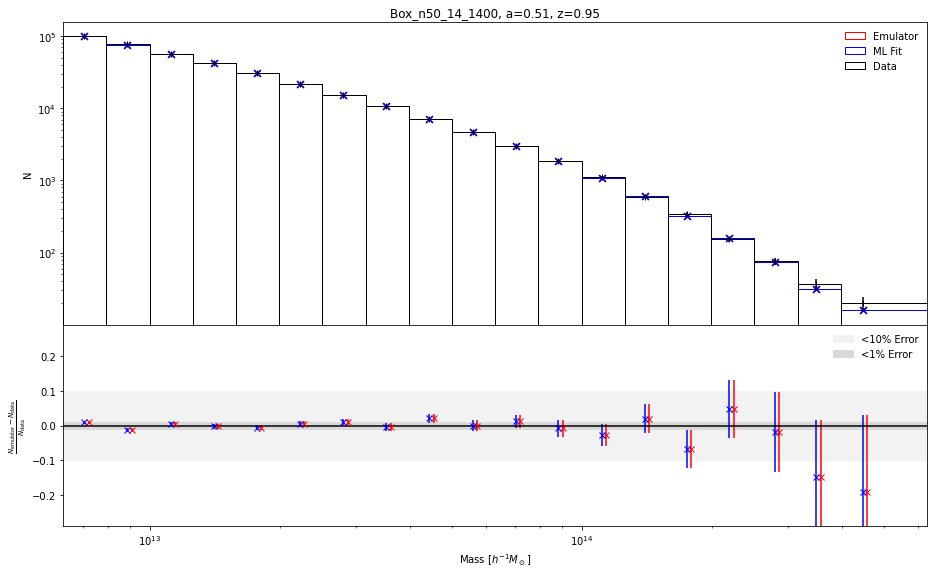

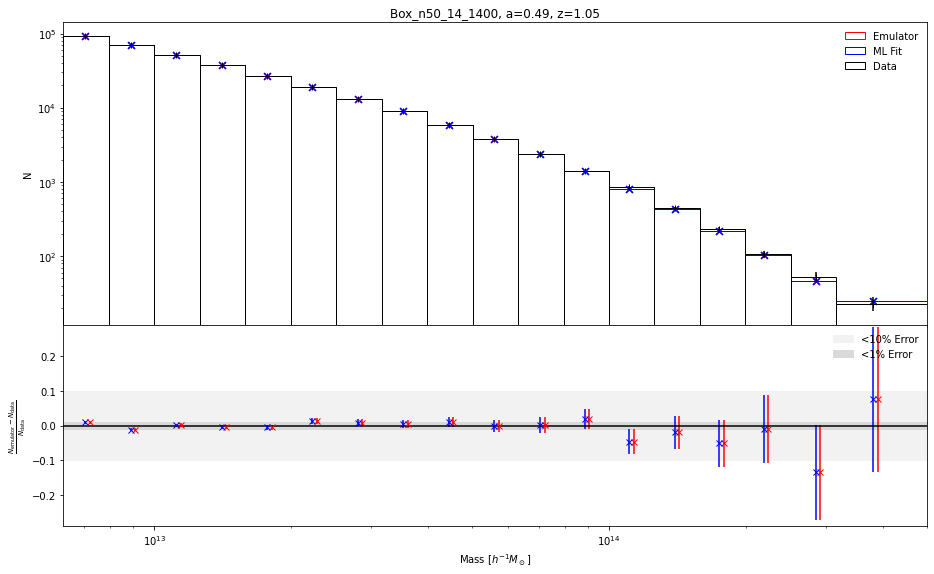

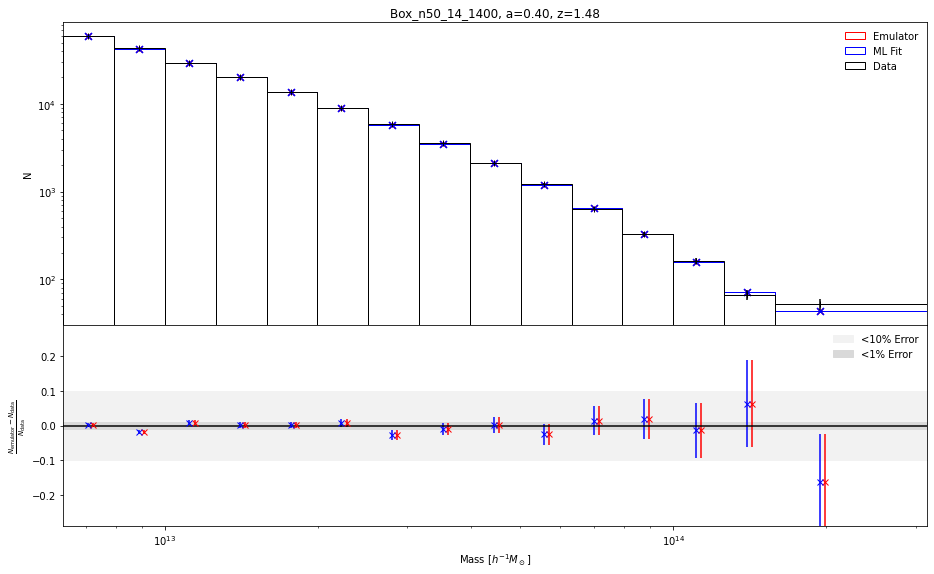

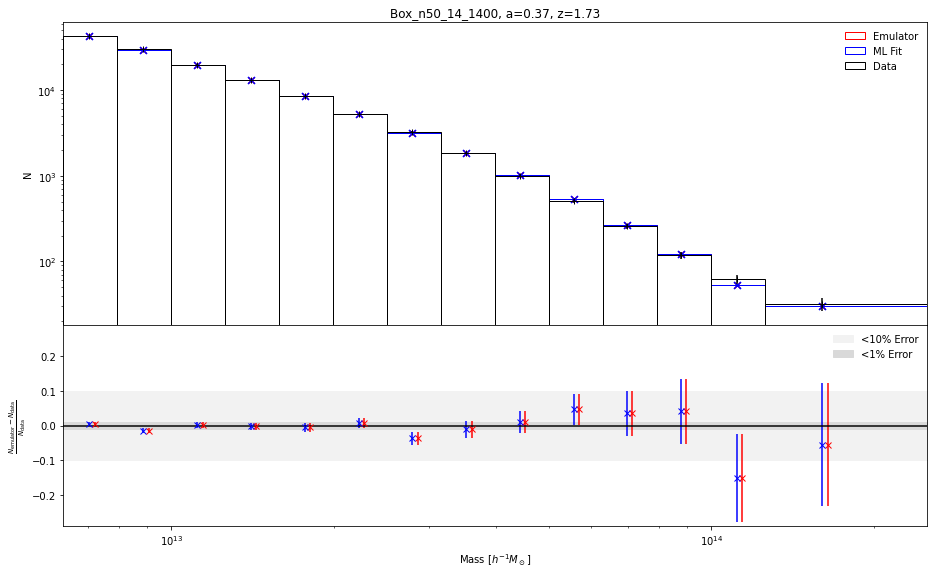

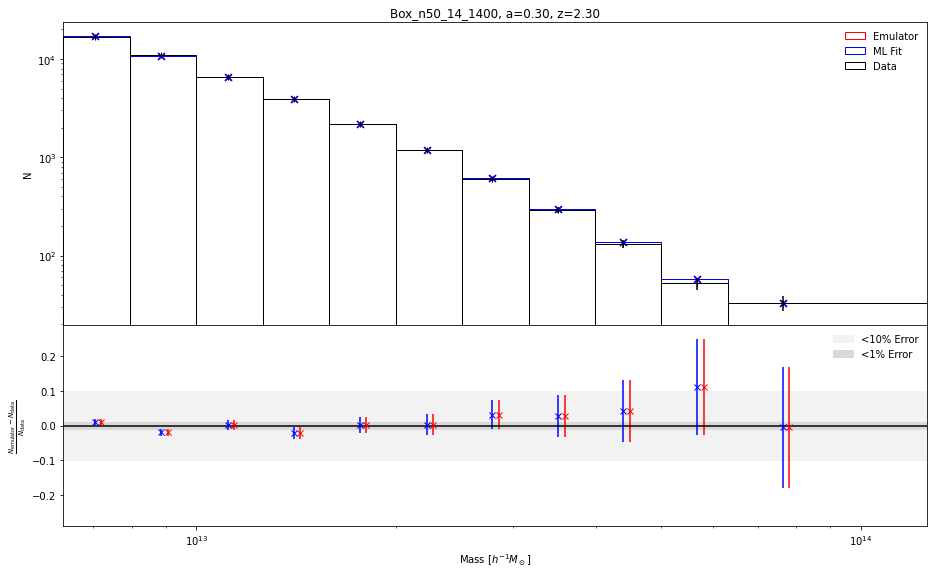

In [15]:
box = 'Box_n50_14_1400'

# from aemulusnu_massfunction.massfunction import *

NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_NvsM.pkl'
NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f) #NvMs is a dictionary of dictionaries
NvM_f.close()

N_data = {}
M_data = {}
aux_data = {}

vol = -1 #Mpc^3/h^3
Mpart = -1

for a in tqdm(a_list):
#     if(a != 1): #TEST
#         continue
    c_data = NvMs[a]

    Ms = c_data['M'] #units of h^-1 Msolar
    N = c_data['N']
    edge_pairs = c_data['edge_pairs']
    assert(len(Ms) == len(edge_pairs))
    assert(len(Ms) == len(N))

    if(vol==-1):
        vol = c_data['vol']
    assert(vol == c_data['vol'])

    if(Mpart==-1):
        Mpart = c_data['Mpart']
    assert(Mpart == c_data['Mpart'])

    N_data[a] = []
    M_data[a] = []
    aux_data[a] = []
    for N_curr, M_curr, edge_pair in zip(N, Ms, edge_pairs):
        N_data[a] += [N_curr]
        M_data[a] += [M_curr]
        aux_data[a] += [{'a':a, 'edge_pair':edge_pair}]
M_numerics = np.logspace(np.log10(100*Mpart), 16, 50)

jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_jackknife_covs.pkl'
jackknife_covs_f = open(jackknife_covs_fname, 'rb')
jackknife = pickle.load(jackknife_covs_f)
jackknife_covs_f.close()

jack_covs = {a:jackknife[a][1] for a in N_data}

# Compute the weighted covariance matrix incorporating jackknife and poisson
weighted_cov = {a: jack_covs[a] for a in jack_covs}

param_names = ['d','e','f','g']


true_params = {}

ccl_cosmo = get_ccl_cosmology(tuple(get_cosmo_vals(cosmo_params[box])))

h = cosmo_params[box]['H0']/100


for a in tqdm(a_list):
    yerr = np.sqrt(np.diagonal(weighted_cov[a]))
    fig1 = plt.figure(figsize =(12, 7))

    axs=[fig1.add_axes((0.0,0.4,1,.6)), fig1.add_axes((0.0,0.0,1,.4))]
    plt.subplots_adjust(wspace=0, hspace=0)
    c_data = NvMs[a]

    Ms = M_data[a]
    N = N_data[a]
    edge_pairs = c_data['edge_pairs']

    edges = [edge[0] for edge in edge_pairs]
    edges += [edge_pairs[-1][1]]

    #shade in 1% and 10% error region
    edges = np.array(edges)
    
    

    y1 = 0.1*np.ones_like(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.1*np.ones_like(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    c_Ms = np.append(Ms, edges[-1])
    c_Ms = np.append(edges[0], c_Ms)
    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.95',label='<10% Error')

    y1 = 0.01*np.ones_like(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.01*np.ones_like(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.85',label='<1% Error')


    dM = np.array([edges[1]-edges[0] for edges in edge_pairs])


    #Emulator 
    f_dNdM_MCMC =  lambda M:Emulator(ccl_cosmo, M/h, a)*vol/(h**3 * M * np.log(10)) # h / Msun
    tinker_eval_MCMC = np.array([quad(f_dNdM_MCMC, edge[0],  edge[1], epsabs=0, epsrel=1e-5)[0] for edge in edge_pairs])

    axs[0].scatter(Ms, tinker_eval_MCMC, marker='x', c='red')
    axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges),
               align='edge', fill=False, ec='red', label='Emulator')
    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_NvMemulator_loo_output.pkl"%(box, a), "wb") as f:
        pickle.dump({'Ms':Ms, 'tinker_eval':tinker_eval_MCMC, 'N':N, 'edges':edges}, f)

    tmp = np.array([c_tmp*10**(0.01)-c_tmp for c_tmp in Ms])
    axs[1].errorbar(Ms + tmp, (tinker_eval_MCMC-N)/N, yerr/N, fmt='x', color='red')

    #ML Fit

    mass_function = MassFuncAemulusNu_fitting_all_snapshot()
    
    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_params.pkl"%(box), "rb") as f:
        MLE_params = pickle.load(f)
        print(list(MLE_params.values()))
        mass_function.set_params(list(MLE_params.values()))


    f_dNdM_MCMC =  lambda M:mass_function(ccl_cosmo, M/h, a)*vol/(h**3 * M * np.log(10)) # h / Msun
    tinker_eval_MCMC = np.array([quad(f_dNdM_MCMC, edge[0],  edge[1], epsabs=0, epsrel=1e-5)[0] for edge in edge_pairs])
    axs[0].scatter(Ms, tinker_eval_MCMC, s=50 , marker='x', c='blue')
    axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges), 
               align='edge', fill=False, ec='blue', label='ML Fit')
    axs[1].errorbar(Ms, (tinker_eval_MCMC-N)/N, yerr/N, fmt='x', color='blue')



    #Data
    axs[0].bar(x=edges[:-1], height=N, width=np.diff(edges),
           align='edge', fill=False, ec='black', label='Data')
    axs[0].errorbar(Ms, N, yerr, fmt='+', c='black')

    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].legend(frameon=False)
    axs[0].set_ylabel('N')

    axs[1].set_xscale('log')
    # axs[1].set_yscale('lin', linthresh=1e-2)    
    axs[1].legend(frameon=False)
    axs[1].axhline(0, c='black')
    axs[1].set_ylabel('N')
    axs[1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')
    axs[1].set_ylabel(r'$\frac{N_{\rm emulator}-N_{\rm data}}{N_{\rm data}} $')
    axs[0].set_title('%s, a=%.2f, z=%.2f'%(box, a, scaleToRedshift(a)))

    left = np.ceil(np.log10(200*Mpart) * 10) / 10
    axs[0].set_xlim((10**left, np.max(edges)))
    axs[1].set_xlim((10**left, np.max(edges)))
    axs[1].set_ylim((-.29, .29))
    axs[1].set_yticks([-.2, -.1, 0, .1, .2])

#     plt.savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/emulator/%s_emufit_%.2f.pdf'%(box, a), bbox_inches='tight')